# INTRO

## Notebook for applying Data Assimilation on seasonal data (Lutetian reconstructions)

### Assemble data in the proxy domain using offline (block update) assimilation instead of point-by-point
### Assemble data in SST (D47), SAT (D47), SSS (d18Oc) and precipitation domain

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assistant Professor Vrije Universiteit Amsterdam

**References used in coding**

*Data assimiliation*
- Steiger, N.J., Hakim, G.J., Steig, E.J., Battisti, D.S., Roe, G.H., 2014. Assimilation of Time-Averaged Pseudoproxies for Climate Reconstruction. Journal of Climate 27, 426–441. https://doi.org/10.1175/JCLI-D-12-00693.1
- Hakim, G.J., Emile-Geay, J., Steig, E.J., Noone, D., Anderson, D.M., Tardif, R., Steiger, N., Perkins, W.A., 2016. The last millennium climate reanalysis project: Framework and first results. Journal of Geophysical Research: Atmospheres 121, 6745–6764. https://doi.org/10.1002/2016JD024751
- King, J., Tierney, J., Osman, M., Judd, E.J., Anchukaitis, K.J., 2023. DASH: a MATLAB toolbox for paleoclimate data assimilation. Geoscientific Model Development 16, 5653–5683. https://doi.org/10.5194/gmd-16-5653-2023
- Judd, E.J., Tierney, J.E., Lunt, D.J., Montañez, I.P., Huber, B.T., Wing, S.L., Valdes, P.J., 2024. A 485-million-year history of Earth’s surface temperature. Science 385, eadk3705. https://doi.org/10.1126/science.adk3705

*Data sources*
- Van Horebeek, N., de Winter, N. J., Baatsen, M., Ziegler, M., Speijer, R. P., Vellekoop, J.: A European Monsoon-like climate in a Warmhouse World, Nature Communications, *in review*, 2025.
- Baatsen, M., von der Heydt, A.S., Huber, M., Kliphuis, M.A., Bijl, P.K., Sluijs, A., Dijkstra, H.A., 2020. The middle to late Eocene greenhouse climate modelled using the CESM 1.0.5. Climate of the Past 16, 2573–2597. https://doi.org/10.5194/cp-16-2573-2020

*Calibration equations*
- Harwood, A. J. P., Dennis, P. F., Marca, A. D., Pilling, G. M., and Millner, R. S.: The oxygen isotope composition of water masses within the North Sea, Estuarine, Coastal and Shelf Science, 78, 353–359, https://doi.org/10.1016/j.ecss.2007.12.010, 2008.
- Daëron, M. and Vermeesch, P.: Omnivariant generalized least squares regression: Theory, geochronological applications, and making the case for reconciled Δ47 calibrations, Chemical Geology, 121881, https://doi.org/10.1016/j.chemgeo.2023.121881, 2023.
- Grossman, E. L. and Ku, T.-L.: Oxygen and carbon isotope fractionation in biogenic aragonite: temperature effects, Chemical Geology: Isotope Geoscience section, 59, 59–74, 1986.
- Gonfiantini, R., Stichler, W., and Rozanski, K.: Standards and intercomparison materials distributed by the International Atomic Energy Agency for stable isotope measurements, 1995.
- Dettman, D. L., Reische, A. K., and Lohmann, K. C.: Controls on the stable isotope composition of seasonal growth bands in aragonitic fresh-water bivalves (Unionidae), Geochimica et Cosmochimica Acta, 63, 1049–1057, 1999.

# Load packages

In [25]:
# Load packages
import numpy as np # The 'numpy' package is needed for matrix operations and calculations
import pandas as pd # The 'pandas' package helps us to import and manage data
import math as math # Math package for data cleaning
from scipy import stats # Import scipy.package for confidence intervals
from sklearn.preprocessing import StandardScaler # Import the package for standardizing data
import D47calib as D47c # Import the package for treating clumped isotope data by Daëron and Vermeesch (2023; https://github.com/mdaeron/D47calib)
import matplotlib.pyplot as plt # The 'matplotlib' package contains tools needed to plot our data and results
import seaborn as sns # The 'seaborn' package is used to make our plots look nicer (e.g. enable heatmaps)
import warnings # The 'warnings' package is used to suppress warnings that might occur during the calculations
%matplotlib inline

# PRIOR - MONTHLY
## Load monthly SAT model data

In [26]:
# Load model SAT data as prior and show data structure
Lutetian_SAT = pd.read_csv('Lutetian case/SAT_Individual_values.csv') # Load the data for this assignment into Python and in the Jupyter environment.
Lutetian_SAT.head()

,Month,Temperature
0,1,11.282648
1,1,21.823206
2,1,21.909296
3,1,22.503198
4,1,21.393762


## Load monthly SST model data

In [27]:
# Load model SST data as prior and show data structure
Lutetian_SST = pd.read_csv('Lutetian case/SST_Individual_values.csv') # Load the data for this assignment into Python and in the Jupyter environment.
Lutetian_SST.head()

,Month,SST
0,1,25.653111
1,1,25.308791
2,1,24.928478
3,1,18.123590
4,1,18.129648


## Load monthly SSS model data

In [28]:
# Load model SSS data as prior and show data structure
Lutetian_SSS = pd.read_csv('Lutetian case/SSS_Individual_values.csv') # Load the data for this assignment into Python and in the Jupyter environment.
Lutetian_SSS.head()

,Month,SSS
0,1,35.445849
1,1,35.447266
2,1,35.370330
3,1,27.677744
4,1,27.647815


## Load monthly precipitation model data

In [29]:
# Load model precipitation data as prior and show data structure
Lutetian_prec = pd.read_csv('Lutetian case/Precipitation_Individual_values.csv') # Load the data for this assignment into Python and in the Jupyter environment.
Lutetian_prec.head()

,Month,Precipitation
0,1,0.352807
1,1,0.114865
2,1,0.225590
3,1,0.224708
4,1,0.214614


### Combine SAT and precipitation data by modelname

In [30]:
# Add a column to number the rows within each month consecutively
Lutetian_SAT['Cell'] = Lutetian_SAT.groupby('Month').cumcount() + 1
Lutetian_SST['Cell'] = Lutetian_SST.groupby('Month').cumcount() + 1
Lutetian_SSS['Cell'] = Lutetian_SSS.groupby('Month').cumcount() + 1
Lutetian_prec['Cell'] = Lutetian_prec.groupby('Month').cumcount() + 1

# Pivot the datasets to create separate columns for each month with 2-letter abbreviations
month_abbreviations = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']
Lutetian_SAT_wide = Lutetian_SAT.pivot(index='Cell', columns='Month', values='Temperature')
Lutetian_SAT_wide.columns = [month_abbreviations[col - 1] for col in Lutetian_SAT_wide.columns]
Lutetian_SST_wide = Lutetian_SST.pivot(index='Cell', columns='Month', values='SST')
Lutetian_SST_wide.columns = [month_abbreviations[col - 1] for col in Lutetian_SST_wide.columns]
Lutetian_SSS_wide = Lutetian_SSS.pivot(index='Cell', columns='Month', values='SSS')
Lutetian_SSS_wide.columns = [month_abbreviations[col - 1] for col in Lutetian_SSS_wide.columns]
Lutetian_prec_wide = Lutetian_prec.pivot(index='Cell', columns='Month', values='Precipitation')
Lutetian_prec_wide.columns = [month_abbreviations[col - 1] for col in Lutetian_prec_wide.columns]

# Reset the index to make 'Cell' a column again
Lutetian_SAT_wide.reset_index(inplace = True)
Lutetian_SST_wide.reset_index(inplace = True)
Lutetian_SSS_wide.reset_index(inplace = True)
Lutetian_prec_wide.reset_index(inplace = True)

# Merge the datasets of SAT, SST, SSS and prec, force suffixes to be added to the column names
# Merge in two steps to circumvent different numbers of cells due to differing spatial resolution in air and ocean models
Lutetian_models = pd.merge(
    # Merge SAT and prec data
    pd.merge(
        Lutetian_SAT_wide.rename(columns = {c: c+'_SAT' for c in Lutetian_SAT_wide.columns if c != 'Cell'}),
        Lutetian_prec_wide.rename(columns = {c: c+'_precip' for c in Lutetian_prec_wide.columns if c != 'Cell'}),
        on = 'Cell',
        how = 'outer'
    ),
    # Merge SST and SSS data
    pd.merge(
        Lutetian_SST_wide.rename(columns = {c: c+'_SST' for c in Lutetian_SST_wide.columns if c != 'Cell'}),
        Lutetian_SSS_wide.rename(columns = {c: c+'_SSS' for c in Lutetian_SSS_wide.columns if c != 'Cell'}),
        on = 'Cell',
        how = 'outer'
    ),
    on = 'Cell',
    how = 'outer'
)

# Display the combined dataset
Lutetian_models.head()

,Cell,ja_SAT,fb_SAT,mr_SAT,ar_SAT,my_SAT,jn_SAT,jl_SAT,ag_SAT,sp_SAT,...,mr_SSS,ar_SSS,my_SSS,jn_SSS,jl_SSS,ag_SSS,sp_SSS,ot_SSS,nv_SSS,dc_SSS
0,1,11.282648,12.089380,13.829187,16.709039,22.411493,27.940820,30.968195,31.072290,26.694391,...,35.461410,35.476315,35.502321,35.524816,35.519439,35.469567,35.353144,35.262145,35.298730,35.386242
1,2,21.823206,22.185327,23.480707,25.735864,30.242242,35.107660,38.680688,39.036523,35.629755,...,35.474837,35.491815,35.518168,35.535836,35.529558,35.499538,35.409034,35.322384,35.326226,35.393769
2,3,21.909296,22.198022,23.222040,25.234583,29.434015,34.056543,38.089227,38.691492,35.554956,...,35.391840,35.407201,35.434341,35.446876,35.436236,35.413111,35.338840,35.276135,35.276722,35.330491
3,4,22.503198,22.530481,23.346246,25.152704,28.970605,33.480951,37.780298,38.492792,35.470605,...,27.740462,27.669306,27.565980,27.477787,27.376960,27.298817,27.239179,27.249114,27.380852,27.560293
4,5,21.393762,21.576868,22.996118,25.669275,30.826440,36.038263,40.872888,40.882013,36.701257,...,27.695703,27.609018,27.476092,27.362065,27.253544,27.175085,27.119611,27.145849,27.320097,27.518127


## Calculate the monthly prior for model SST, SAT, SSS and precipitation values

In [31]:
# Create list of month names
months = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']

# Prior SST, SAT, SSS & precipitation estimates from climate models (mean)
mu_prior_SAT_monthly = np.array(Lutetian_models[[f"{month}_SAT" for month in months]].mean(axis=0, skipna=True))
mu_prior_SST_monthly = np.array(Lutetian_models[[f"{month}_SST" for month in months]].mean(axis=0, skipna=True))
mu_prior_SSS_monthly = np.array(Lutetian_models[[f"{month}_SSS" for month in months]].mean(axis=0, skipna=True))
mu_prior_precip_monthly = np.array(Lutetian_models[[f"{month}_precip" for month in months]].mean(axis=0, skipna=True))

# Covariance between months in prior SST, SAT, SSS, and precip estimates from climate models (covariance matrix)
cov_prior_SAT_monthly = np.cov(Lutetian_models[[f"{month}_SAT" for month in months]].dropna(), rowvar=False)
cov_prior_SST_monthly = np.cov(Lutetian_models[[f"{month}_SST" for month in months]].dropna(), rowvar=False)
cov_prior_SSS_monthly = np.cov(Lutetian_models[[f"{month}_SSS" for month in months]].dropna(), rowvar=False)
cov_prior_precip_monthly = np.cov(Lutetian_models[[f"{month}_precip" for month in months]].dropna(), rowvar=False)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SAT_monthly_original, cov_prior_SAT_monthly_original = mu_prior_SAT_monthly.copy(), cov_prior_SAT_monthly.copy()
mu_prior_SST_monthly_original, cov_prior_SST_monthly_original = mu_prior_SST_monthly.copy(), cov_prior_SST_monthly.copy()
mu_prior_SSS_monthly_original, cov_prior_SSS_monthly_original = mu_prior_SSS_monthly.copy(), cov_prior_SSS_monthly.copy()
mu_prior_precip_monthly_original, cov_prior_precip_monthly_original = mu_prior_precip_monthly.copy(), cov_prior_precip_monthly.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SAT_monthly = np.sqrt(np.diag(cov_prior_SAT_monthly))
std_prior_SST_monthly = np.sqrt(np.diag(cov_prior_SST_monthly))
std_prior_SSS_monthly = np.sqrt(np.diag(cov_prior_SSS_monthly))
std_prior_precip_monthly = np.sqrt(np.diag(cov_prior_precip_monthly))

print("SAT Monthly Means:", mu_prior_SAT_monthly)
print("SAT Monthly Std Devs:", std_prior_SAT_monthly)
print("SST Monthly Means:", mu_prior_SST_monthly)
print("SST Monthly Std Devs:", std_prior_SST_monthly)
print("SSS Monthly Means:", mu_prior_SSS_monthly)
print("SSS Monthly Std Devs:", std_prior_SSS_monthly)
print("Precip Monthly Means:", mu_prior_precip_monthly)
print("Precip Monthly Std Devs:", std_prior_precip_monthly)

SAT Monthly Means: [16.27954224 17.01156006 18.66868896 21.54889648 27.12244995 32.0811853
 35.76927734 35.78623779 32.02878784 25.72896606 20.42561768 17.17369751]
SAT Monthly Std Devs: [3.46377896 3.10594374 2.78918732 2.54271169 2.46488387 2.73331005
 2.85535749 2.646315   2.52596201 3.00791784 3.58824735 3.69933077]
SST Monthly Means: [23.86139364 23.17810472 23.14772474 23.92908666 26.57514352 30.58667586
 34.10417351 35.48879139 34.18526063 31.27739675 28.24302759 25.51228172]
SST Monthly Std Devs: [2.83903042 2.98635231 2.95864974 2.74006009 2.42216397 2.22547687
 2.02150675 1.9040936  1.73710814 1.64930877 2.07319756 2.54273385]
SSS Monthly Means: [34.48952147 34.48138433 34.46366809 34.44571124 34.43899317 34.43806975
 34.41677989 34.40664036 34.40840345 34.436755   34.46977234 34.49277948]
SSS Monthly Std Devs: [3.01539682 2.98680818 2.97232063 2.97675101 3.00281989 3.03418516
 3.0716477  3.107458   3.13625919 3.14157102 3.10472103 3.05326323]
Precip Monthly Means: [0.2050364

## Plot the monthly priors for all model values

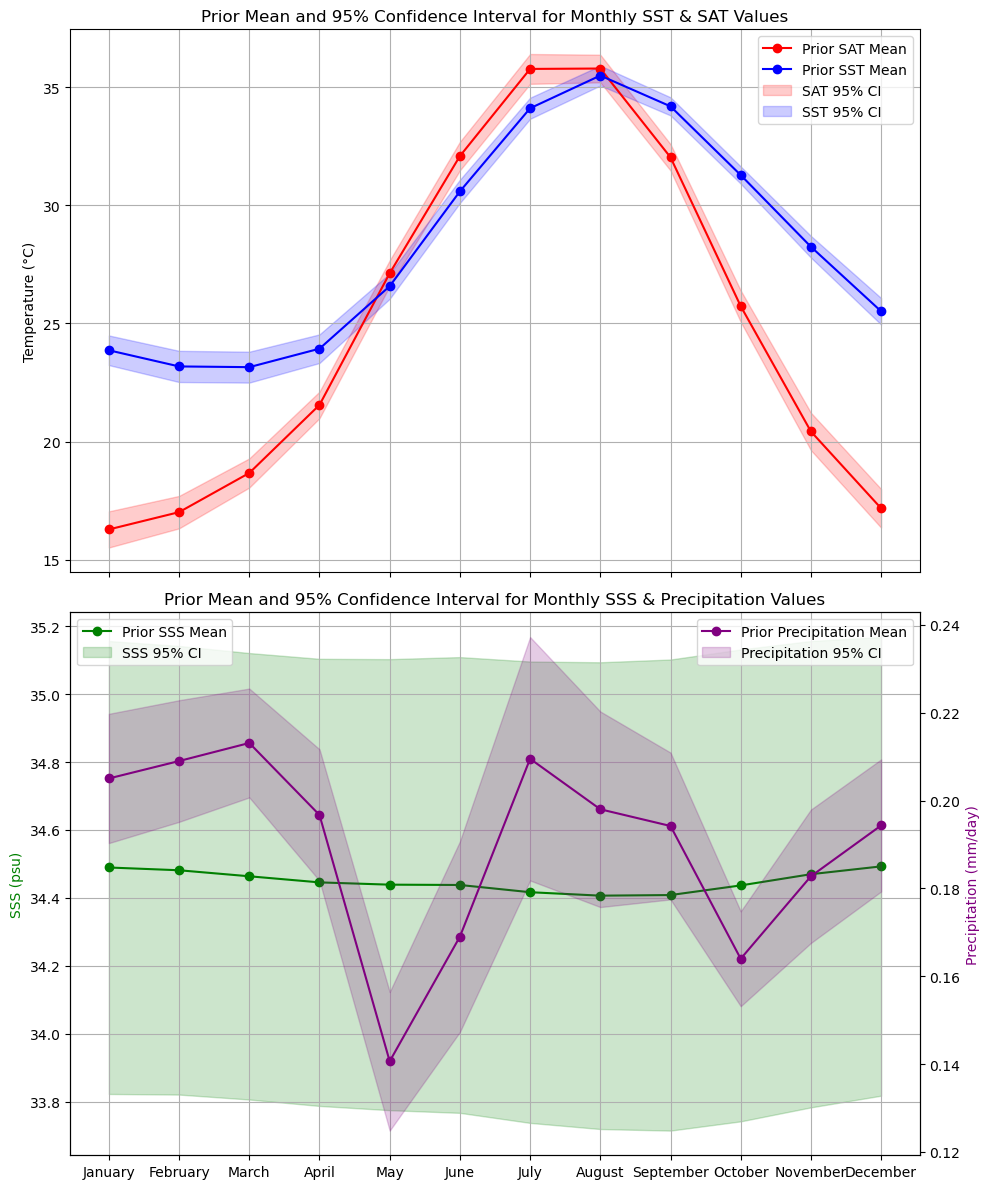

In [32]:
# Set dimensions of data
n_models_monthly = len(Lutetian_models["Cell"])  # Find the total number of models (use monthly data because monthly data has this column duplicated 3 times)

# Create a monthly scale for the x-axis
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']  # List full month names
months_scale = np.arange(len(months)) + 1  # Create monthly scale

# Create the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Panel 1: Plot the prior distribution for SST and SAT
axes[0].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker='o', color='r')
axes[0].plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o', color='b')

# Add 95% confidence intervals for SAT
axes[0].fill_between(
    months_scale,
    mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, color='r', label='SAT 95% CI'
)

# Add 95% confidence intervals for SST
axes[0].fill_between(
    months_scale,
    mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
    mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, color='b', label='SST 95% CI'
)

axes[0].set_title('Prior Mean and 95% Confidence Interval for Monthly SST & SAT Values')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()
axes[0].grid(True)

# Panel 2: Plot the prior distribution for SSS and precipitation
axes[1].plot(months_scale, mu_prior_SSS_monthly, label='Prior SSS Mean', marker='o', color='g')
ax2 = axes[1].twinx()  # Create a secondary y-axis for precipitation
ax2.plot(months_scale, mu_prior_precip_monthly, label='Prior Precipitation Mean', marker='o', color='purple')

# Add 95% confidence intervals for SSS
axes[1].fill_between(
    months_scale,
    mu_prior_SSS_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly),
    mu_prior_SSS_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, color='g', label='SSS 95% CI'
)

# Add 95% confidence intervals for precipitation
ax2.fill_between(
    months_scale,
    mu_prior_precip_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    mu_prior_precip_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, color='purple', label='Precipitation 95% CI'
)

axes[1].set_ylabel('SSS (psu)', color='g')
ax2.set_ylabel('Precipitation (mm/day)', color='purple')
axes[1].set_title('Prior Mean and 95% Confidence Interval for Monthly SSS & Precipitation Values')
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')
axes[1].grid(True)

# Update the x-axis with month names
plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.xlabel('Month')
plt.tight_layout()
plt.show()

### Convert SAT and SST model data to D47 domain using the regression by Daëron and Vermeesch (2023) and propagate uncertainty in the calibration

In [33]:
# Apply T47()-function from the D47calib package to all SAT columns
# Identify the SAT columns
SAT_columns = [col for col in Lutetian_models.columns if col.endswith('_SAT')]
SST_columns = [col for col in Lutetian_models.columns if col.endswith('_SST')]

# Apply the conversion function to the SAT columns and add new columns for D47 and D47_SE
for col in SAT_columns:
    base_col_name = col.replace('_SAT', '') # Remove the '_SAT' suffix from the column name
    Lutetian_models[f'{base_col_name}_SAT_D47'], Lutetian_models[f'{base_col_name}_SAT_D47_SE'] = zip(*Lutetian_models[col].apply(
        lambda x: D47c.OGLS23.T47(T = x) if not pd.isna(x) else (np.nan, np.nan)
    )) # Use zip() to unpack the tuple returned by the apply() method and apply the T47()-function to each value in the column
for col in SST_columns:
    base_col_name = col.replace('_SST', '') # Remove the '_SST' suffix from the column name
    Lutetian_models[f'{base_col_name}_SST_D47'], Lutetian_models[f'{base_col_name}_SST_D47_SE'] = zip(*Lutetian_models[col].apply(
        lambda x: D47c.OGLS23.T47(T = x) if not pd.isna(x) else (np.nan, np.nan)
    )) # Use zip() to unpack the tuple returned by the apply() method and apply the T47()-function to each value in the column

# Display the combined data with D47 and D47_SE columns
D47_columns = [col for col in Lutetian_models.columns if col.endswith('_D47')]
D47_se_columns = [col for col in Lutetian_models.columns if '_D47_SE' in col]
print("D47 values for all model outcomes:\n", Lutetian_models[D47_columns].head())
print("Calibration standard errors for all model outcomes:\n", Lutetian_models[D47_se_columns].head())

D47 values for all model outcomes:
    ja_SAT_D47  fb_SAT_D47  mr_SAT_D47  ar_SAT_D47  my_SAT_D47  jn_SAT_D47  \
0    0.637865    0.635067    0.629115    0.619502    0.601307    0.584664   
1    0.603134    0.602008    0.598014    0.591188    0.578009    0.564439   
2    0.602866    0.601969    0.598808    0.592691    0.580329    0.567315   
3    0.601023    0.600939    0.598426    0.592938    0.581667    0.568903   
4    0.604475    0.603903    0.599502    0.591387    0.576345    0.561918   

   jl_SAT_D47  ag_SAT_D47  sp_SAT_D47  ot_SAT_D47  ...  mr_SST_D47  \
0    0.575942    0.575647    0.588334    0.607248  ...    0.593324   
1    0.554885    0.553952    0.563022    0.577000  ...    0.594240   
2    0.556444    0.554857    0.563225    0.577214  ...    0.595136   
3    0.557261    0.555379    0.563453    0.576950  ...    0.618591   
4    0.549188    0.549164    0.560136    0.577425  ...    0.618968   

   ar_SST_D47  my_SST_D47  jn_SST_D47  jl_SST_D47  ag_SST_D47  sp_SST_D47  \
0  

### Estimate seawater oxygen isotope value from salinity based on modern North Sea d18Ow-salinity relationship by Harwood et al. (2007)

In [34]:
# Apply the d18Ow-SSS function from Harwood et al. (2007) to all SSS columns
# Identify the SSS columns
SSS_columns = [col for col in Lutetian_models.columns if col.endswith('_SSS')]

# Apply the conversion function to the SSS columns and add new columns for d18Ow and d18Ow_SE
for col in SSS_columns:
    base_col_name = col.replace('_SSS', '')  # Remove the '_SSS' suffix from the column name
    Lutetian_models[f'{base_col_name}_SSS_d18Ow'] = Lutetian_models[col].apply(
        lambda x: -9.300 + 0.274 * x if not pd.isna(x) else np.nan  # Calculate d18Ow
    )

# Display the combined data with d18Ow and d18Ow_SE columns
d18Ow_columns = [col for col in Lutetian_models.columns if col.endswith('_d18Ow')]
print("d18Ow values for all model outcomes:\n", Lutetian_models[d18Ow_columns].head())

d18Ow values for all model outcomes:
    ja_SSS_d18Ow  fb_SSS_d18Ow  mr_SSS_d18Ow  ar_SSS_d18Ow  my_SSS_d18Ow  \
0      0.412163      0.417397      0.416426      0.420510      0.427636   
1      0.412551      0.419215      0.420105      0.424757      0.431978   
2      0.391470      0.397124      0.397364      0.401573      0.409009   
3     -1.716298     -1.696593     -1.699113     -1.718610     -1.746921   
4     -1.724499     -1.705170     -1.711377     -1.735129     -1.771551   

   jn_SSS_d18Ow  jl_SSS_d18Ow  ag_SSS_d18Ow  sp_SSS_d18Ow  ot_SSS_d18Ow  \
0      0.433800      0.432326      0.418661      0.386762      0.361828   
1      0.436819      0.435099      0.426873      0.402075      0.378333   
2      0.412444      0.409529      0.403192      0.382842      0.365661   
3     -1.771086     -1.798713     -1.820124     -1.836465     -1.833743   
4     -1.802794     -1.832529     -1.854027     -1.869227     -1.862037   

   nv_SSS_d18Ow  dc_SSS_d18Ow  
0      0.371852      0.39583

### Calculate carbonate oxygen isotope value from SST and seawater oxygen isotope data using Grossman and Ku (1986) with the VPDB-VSMOW scale correction by Gonfiantini et al. (1995) and Dettman et al. (1999)

In [35]:
# Iterate over each model and calculate d18Oc values
for index, row in Lutetian_models.iterrows():
    # Iterate over each month
    for month in months:
        SST = row[f"{month}_SST"]
        d18Ow = row[f"{month}_SSS_d18Ow"]
        if not pd.isna(SST) and not pd.isna(d18Ow):
            d18Oc = (20.6 - SST) / 4.34 + (d18Ow - 0.27)
        else:
            d18Oc = np.nan
        # Add the calculated d18Oc value to the DataFrame
        Lutetian_models.loc[index, f"{month}_d18Oc"] = d18Oc

# Display the updated DataFrame
Lutetian_models.head()


,Cell,ja_SAT,fb_SAT,mr_SAT,ar_SAT,my_SAT,jn_SAT,jl_SAT,ag_SAT,sp_SAT,...,mr_d18Oc,ar_d18Oc,my_d18Oc,jn_d18Oc,jl_d18Oc,ag_d18Oc,sp_d18Oc,ot_d18Oc,nv_d18Oc,dc_d18Oc
0,1,11.282648,12.089380,13.829187,16.709039,22.411493,27.940820,30.968195,31.072290,26.694391,...,-0.873077,-1.040673,-1.619817,-2.513306,-3.213928,-3.583698,-3.367792,-2.744058,-2.032903,-1.408096
1,2,21.823206,22.185327,23.480707,25.735864,30.242242,35.107660,38.680688,39.036523,35.629755,...,-0.799470,-0.929937,-1.466061,-2.347593,-3.014437,-3.384486,-3.208780,-2.633968,-1.938649,-1.313754
2,3,21.909296,22.198022,23.222040,25.234583,29.434015,34.056543,38.089227,38.691492,35.554956,...,-0.754007,-0.877557,-1.403951,-2.289134,-2.948919,-3.317429,-3.148663,-2.580306,-1.883936,-1.240408
3,4,22.503198,22.530481,23.346246,25.152704,28.970605,33.480951,37.780298,38.492792,35.470605,...,-1.136514,-1.384207,-2.130491,-3.116770,-3.959694,-4.334650,-4.195826,-3.656621,-2.769984,-1.943248
4,5,21.393762,21.576868,22.996118,25.669275,30.826440,36.038263,40.872888,40.882013,36.701257,...,-1.122320,-1.360099,-2.106644,-3.107112,-3.975039,-4.357027,-4.219610,-3.656945,-2.755215,-1.950705


### Calculate the monthly prior for model SST- and SAT-derived D47 values and SSS-derived seawater oxygen isotope values with propagated uncertainty

In [36]:
# Set the weights of the data based on the standard errors
weights_monthly_SST_D47 = 1 / Lutetian_models[[f"{month}_SST_D47_SE" for month in months]] ** 2
weights_monthly_SAT_D47 = 1 / Lutetian_models[[f"{month}_SAT_D47_SE" for month in months]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_monthly_SST_D47 to match the headers of the D47 matrix later for multiplication
weights_monthly_SST_D47.columns = [col.replace('_SST_D47_SE', '_SST_D47') for col in weights_monthly_SST_D47.columns]
weights_monthly_SAT_D47.columns = [col.replace('_SAT_D47_SE', '_SAT_D47') for col in weights_monthly_SAT_D47.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_SST_D47_monthly = np.array((Lutetian_models[[f"{month}_SST_D47" for month in months]] * weights_monthly_SST_D47).sum(axis = 0, skipna = True) / weights_monthly_SST_D47.sum(axis = 0, skipna = True)) # Calculate weighted monthly mean D47 values and convert to numpy array
mu_prior_SAT_D47_monthly = np.array((Lutetian_models[[f"{month}_SAT_D47" for month in months]] * weights_monthly_SAT_D47).sum(axis = 0, skipna = True) / weights_monthly_SAT_D47.sum(axis = 0, skipna = True)) # Calculate weighted monthly mean D47 values and convert to numpy array

# Calculate simple (unweighted) mean for monthly d18Ow values
mu_prior_SSS_d18Ow_monthly = np.array(Lutetian_models[[f"{month}_SSS_d18Ow" for month in months]].mean(axis=0, skipna=True))
mu_prior_d18Oc_monthly = np.array(Lutetian_models[[f"{month}_d18Oc" for month in months]].mean(axis=0, skipna=True))

# Decompose variance within and between model outcomes
model_variances_SST = Lutetian_models[[f"{month}_SST_D47" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_SAT = Lutetian_models[[f"{month}_SAT_D47" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_d18Ow = Lutetian_models[[f"{month}_SSS_d18Ow" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_d18Oc = Lutetian_models[[f"{month}_d18Oc" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances_SST = (Lutetian_models[[f"{month}_SST_D47_SE" for month in months]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements
measurement_variances_SAT = (Lutetian_models[[f"{month}_SAT_D47_SE" for month in months]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between months in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_monthly_SST = np.cov(Lutetian_models[[f"{month}_SST_D47" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_monthly_SAT = np.cov(Lutetian_models[[f"{month}_SAT_D47" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_monthly_d18Ow = np.cov(Lutetian_models[[f"{month}_SSS_d18Ow" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_monthly_d18Oc = np.cov(Lutetian_models[[f"{month}_d18Oc" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_D47_monthly = cov_raw_monthly_SST.copy() # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_SAT_D47_monthly = cov_raw_monthly_SAT.copy() # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_SST_D47_monthly, np.diagonal(cov_raw_monthly_SST) + measurement_variances_SST)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)
np.fill_diagonal(cov_prior_SAT_D47_monthly, np.diagonal(cov_raw_monthly_SAT) + measurement_variances_SAT)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SST_D47_monthly_original, cov_prior_SST_D47_monthly_original = mu_prior_SST_D47_monthly.copy(), cov_prior_SST_D47_monthly.copy()
mu_prior_SAT_D47_monthly_original, cov_prior_SAT_D47_monthly_original = mu_prior_SAT_D47_monthly.copy(), cov_prior_SAT_D47_monthly.copy()
mu_prior_SSS_d18Ow_monthly_original, cov_prior_SSS_d18Ow_monthly_original = mu_prior_SSS_d18Ow_monthly.copy(), cov_raw_monthly_d18Ow.copy()
mu_prior_d18Oc_monthly_original, cov_prior_d18Oc_monthly_original = mu_prior_d18Oc_monthly.copy(), cov_raw_monthly_d18Oc.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SST_D47_monthly = np.sqrt(np.diag(cov_prior_SST_D47_monthly))
std_prior_SAT_D47_monthly = np.sqrt(np.diag(cov_prior_SAT_D47_monthly))
std_prior_SSS_d18Ow_monthly = np.sqrt(np.diag(cov_raw_monthly_d18Ow))
std_prior_d18Oc_monthly = np.sqrt(np.diag(cov_raw_monthly_d18Oc))

# Print the results
print("Prior D47 estimates from SST in climate models (weighted mean):")
print(mu_prior_SST_D47_monthly)
print("Prior D47 estimates from SST in climate models (weighted covariance matrix):")
print(std_prior_SST_D47_monthly)
print("Prior D47 estimates from SAT in climate models (weighted mean):")
print(mu_prior_SAT_D47_monthly)
print("Prior D47 estimates from SAT in climate models (weighted covariance matrix):")
print(std_prior_SAT_D47_monthly)
print("Prior d18Ow estimates from SSS in climate models (weighted mean):")
print(mu_prior_SSS_d18Ow_monthly)
print("Prior d18Ow estimates from SSS in climate models (weighted covariance matrix):")
print(std_prior_SSS_d18Ow_monthly)
print("Prior d18Oc estimates from SST and d18Ow in climate models (weighted mean):")
print(mu_prior_d18Oc_monthly)
print("Prior d18Oc estimates from SST and d18Ow in climate models (weighted covariance matrix):")
print(std_prior_d18Oc_monthly)

Prior D47 estimates from SST in climate models (weighted mean):
[0.59656789 0.59858139 0.59867924 0.59638204 0.58858685 0.57705811
 0.56727922 0.56351195 0.5670409  0.57510508 0.58376364 0.59171077]
Prior D47 estimates from SST in climate models (weighted covariance matrix):
[0.00890411 0.00944467 0.00936157 0.00859554 0.00739686 0.00653869
 0.00575527 0.00534817 0.00493985 0.00482531 0.00621776 0.00782822]
Prior D47 estimates from SAT in climate models (weighted mean):
[0.62006985 0.61787124 0.61269573 0.60374682 0.58703137 0.57294061
 0.56290407 0.56283341 0.57307851 0.59111554 0.60696862 0.61709809]
Prior D47 estimates from SAT in climate models (weighted covariance matrix):
[0.01142741 0.01018869 0.0090148  0.00801557 0.00738831 0.00779214
 0.00785649 0.00725533 0.00718243 0.00905268 0.01135674 0.01208698]
Prior d18Ow estimates from SSS in climate models (weighted mean):
[0.15012888 0.14789931 0.14304506 0.13812488 0.13628413 0.13603111
 0.13019769 0.12741946 0.12790254 0.13567087 

### Plot the monthly prior for model SST- and SAT-derived D47 values, model SSS-derived carbonate d18O values and precipitation with propagated uncertainty

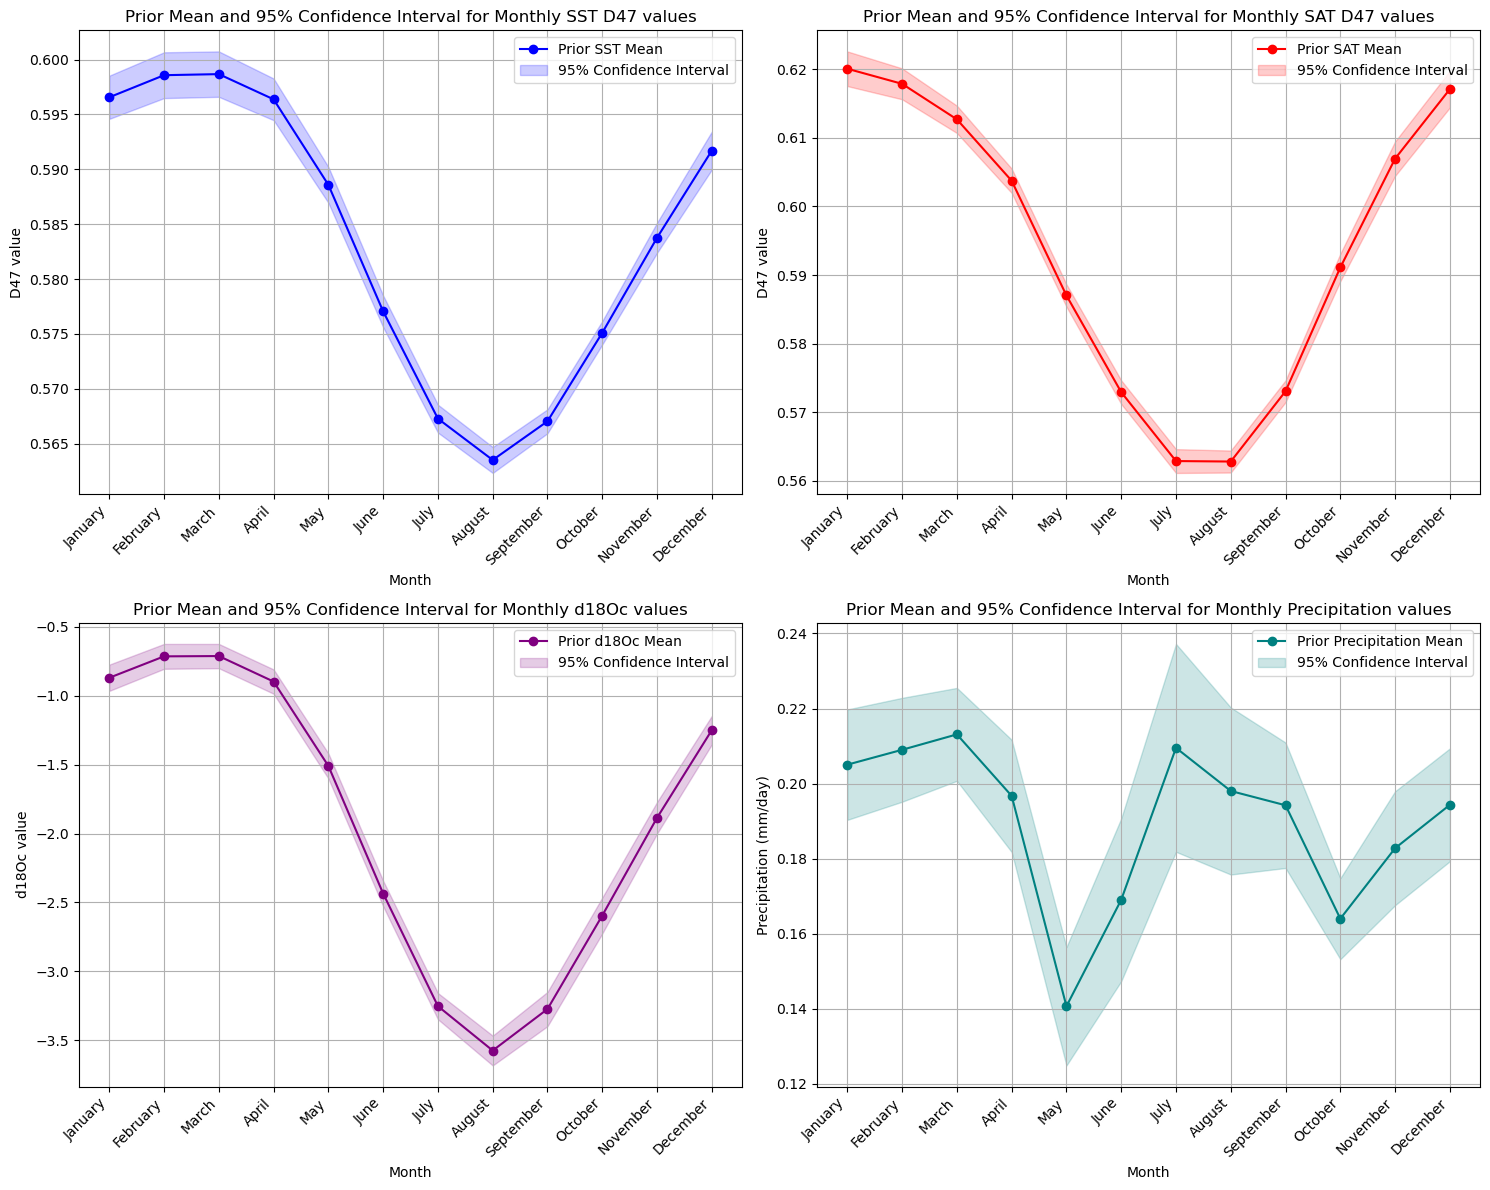

In [37]:
# Plot monthly prior distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # Adjust the figure to have 2x2 grid

# Plot the prior distribution for SST
axes[0, 0].plot(months_scale, mu_prior_SST_D47_monthly, label='Prior SST Mean', color='b', marker='o')
axes[0, 0].fill_between(months_scale,
                        mu_prior_SST_D47_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly / np.sqrt(n_models_monthly),
                        mu_prior_SST_D47_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly / np.sqrt(n_models_monthly),
                        color='b', alpha=0.2, label='95% Confidence Interval')
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_title('Prior Mean and 95% Confidence Interval for Monthly SST D47 values')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('D47 value')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot the prior distribution for SAT
axes[0, 1].plot(months_scale, mu_prior_SAT_D47_monthly, label='Prior SAT Mean', color='r', marker='o')
axes[0, 1].fill_between(months_scale,
                        mu_prior_SAT_D47_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_D47_monthly / np.sqrt(n_models_monthly),
                        mu_prior_SAT_D47_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_D47_monthly / np.sqrt(n_models_monthly),
                        color='r', alpha=0.2, label='95% Confidence Interval')
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_title('Prior Mean and 95% Confidence Interval for Monthly SAT D47 values')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('D47 value')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot the prior distribution for d18Oc
axes[1, 0].plot(months_scale, mu_prior_d18Oc_monthly, label='Prior d18Oc Mean', color='purple', marker='o')
axes[1, 0].fill_between(months_scale,
                        mu_prior_d18Oc_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_d18Oc_monthly / np.sqrt(n_models_monthly),
                        mu_prior_d18Oc_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_d18Oc_monthly / np.sqrt(n_models_monthly),
                        color='purple', alpha=0.2, label='95% Confidence Interval')
axes[1, 0].set_xticks(months_scale)
axes[1, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 0].set_title('Prior Mean and 95% Confidence Interval for Monthly d18Oc values')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('d18Oc value')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot the prior distribution for precipitation
axes[1, 1].plot(months_scale, mu_prior_precip_monthly, label='Prior Precipitation Mean', color='teal', marker='o')
axes[1, 1].fill_between(months_scale,
                        mu_prior_precip_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
                        mu_prior_precip_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
                        color='teal', alpha=0.2, label='95% Confidence Interval')
axes[1, 1].set_xticks(months_scale)
axes[1, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 1].set_title('Prior Mean and 95% Confidence Interval for Monthly Precipitation values')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Precipitation (mm/day)')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Update the layout and show the plot
plt.tight_layout()
plt.show()

## Calculate the monthly covariance matrix for D47 values of SST and SAT, d18Oc and precipitation

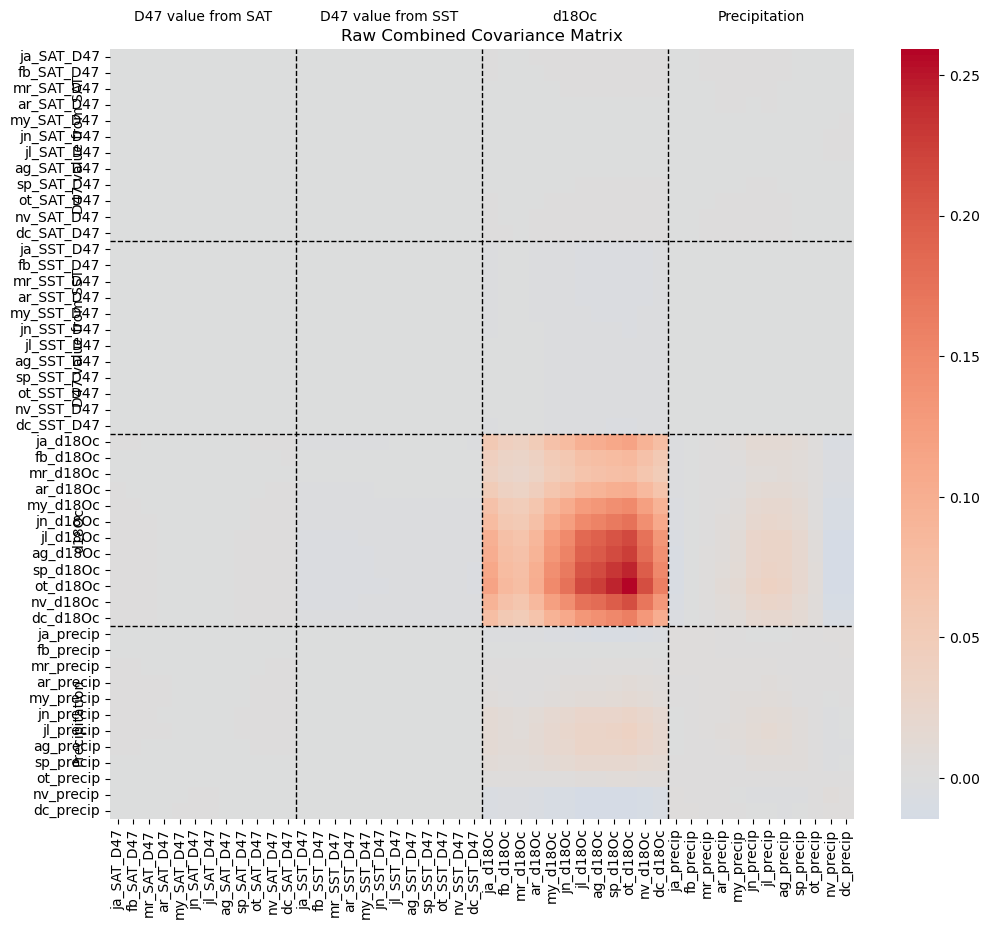

In [38]:
# Define column names for SAT, SST, d18Oc, and precipitation
SAT_D47_columns_monthly = [f"{month}_SAT_D47" for month in months]
SST_D47_columns_monthly = [f"{month}_SST_D47" for month in months]
d18Oc_columns_monthly = [f"{month}_d18Oc" for month in months]
precip_columns_monthly = [f"{month}_precip" for month in months]

# Extract the relevant columns for SAT, SST D47, d18Oc, and precipitation
SAT_D47_columns_monthly = [f"{month}_SAT_D47" for month in months]
SST_D47_columns_monthly = [f"{month}_SST_D47" for month in months]
d18Oc_columns_monthly = [f"{month}_d18Oc" for month in months]
precip_columns_monthly = [f"{month}_precip" for month in months]

# Combine the relevant columns into a single dataframe
combined_data_monthly = Lutetian_models[SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly]

# Calculate the covariance matrix for the combined data
cov_combined_monthly = np.cov(combined_data_monthly.dropna(), rowvar=False)

# Plot the heatmap of the raw combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cov_combined_monthly,  # Use the raw covariance matrix
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly,
    yticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly
)

# Add titles to the axes per parameter
plt.axvline(x=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SAT_D47_columns_monthly) / 2, -2, 'D47 value from SAT', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, -2, 'D47 value from SST', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, -2, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, -2, 'Precipitation', ha='center', va='center', fontsize=10)

plt.text(-2, len(SAT_D47_columns_monthly) / 2, 'D47 value from SAT', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-2, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, 'D47 value from SST', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-2, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, 'd18Oc', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-2, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, 'Precipitation', ha='center', va='center', rotation=90, fontsize=10)

plt.title("Raw Combined Covariance Matrix")
plt.show()

## Plot normalized monthly covariance matrix between D47 values of SST and SAT, d18Oc and precipitation

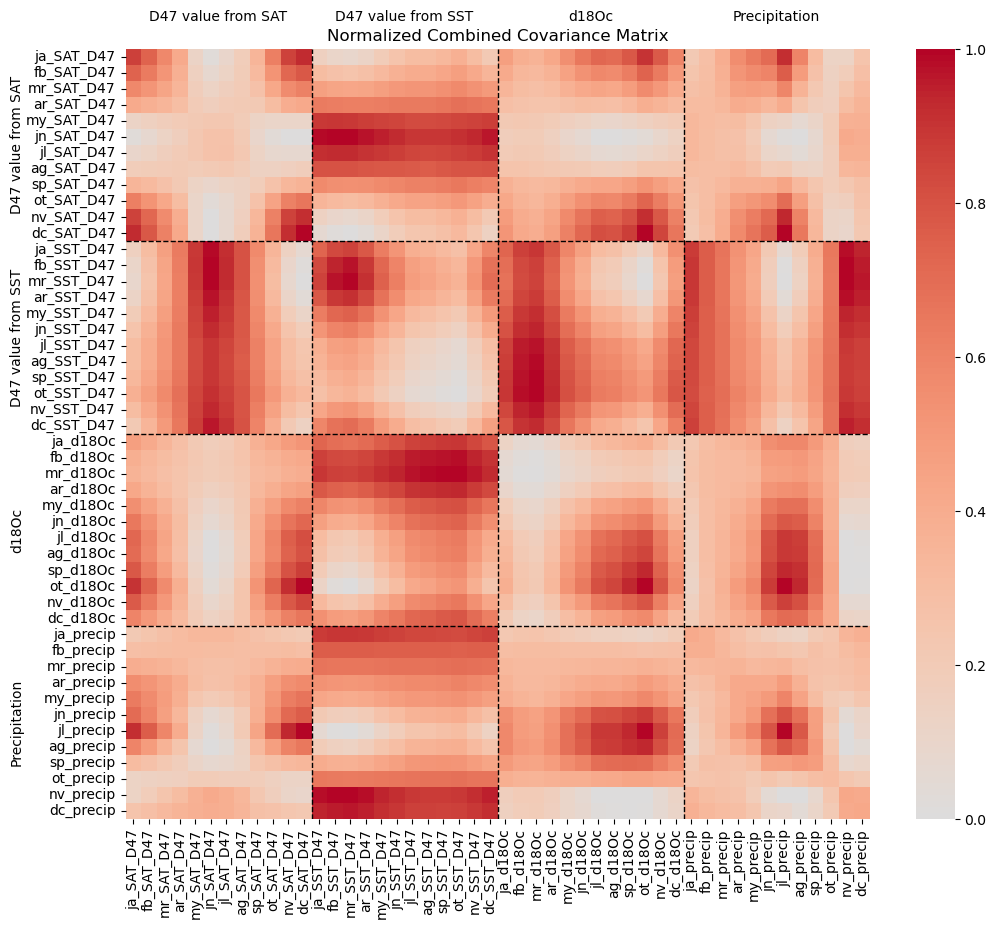

In [39]:
# Normalize each submatrix independently for better visualization
def normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)

# Extract the relevant columns for SAT, SST D47, d18Oc, and precipitation
SAT_D47_columns_monthly = [f"{month}_SAT_D47" for month in months]
SST_D47_columns_monthly = [f"{month}_SST_D47" for month in months]
d18Oc_columns_monthly = [f"{month}_d18Oc" for month in months]
precip_columns_monthly = [f"{month}_precip" for month in months]

# Combine the relevant columns into a single dataframe
combined_data_monthly = Lutetian_models[SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly]

# Calculate the covariance matrix for the combined data
cov_combined_monthly = np.cov(combined_data_monthly.dropna(), rowvar=False)

# Extract the covariance matrices for SAT D47, SST D47, d18Oc, and precipitation
cov_SAT_D47_monthly = cov_combined_monthly[:len(months), :len(months)]
cov_SST_D47_monthly = cov_combined_monthly[len(months):2*len(months), len(months):2*len(months)]
cov_d18Oc_monthly = cov_combined_monthly[2*len(months):3*len(months), 2*len(months):3*len(months)]
cov_precip_monthly = cov_combined_monthly[3*len(months):, 3*len(months):]

# Extract the cross-covariance matrices
cross_cov_SAT_SST_D47_monthly = cov_combined_monthly[:len(months), len(months):2*len(months)]
cross_cov_SAT_d18Oc_monthly = cov_combined_monthly[:len(months), 2*len(months):3*len(months)]
cross_cov_SAT_precip_monthly = cov_combined_monthly[:len(months), 3*len(months):]
cross_cov_SST_d18Oc_monthly = cov_combined_monthly[len(months):2*len(months), 2*len(months):3*len(months)]
cross_cov_SST_precip_monthly = cov_combined_monthly[len(months):2*len(months), 3*len(months):]
cross_cov_d18Oc_precip_monthly = cov_combined_monthly[2*len(months):3*len(months), 3*len(months):]

# Normalize each submatrix
normalized_cov_SAT_D47_monthly = normalize_matrix(cov_SAT_D47_monthly)
normalized_cov_SST_D47_monthly = normalize_matrix(cov_SST_D47_monthly)
normalized_cov_d18Oc_monthly = normalize_matrix(cov_d18Oc_monthly)
normalized_cov_precip_monthly = normalize_matrix(cov_precip_monthly)

# Normalize each cross-covariance matrix
normalized_cross_cov_SAT_SST_D47_monthly = normalize_matrix(cross_cov_SAT_SST_D47_monthly)
normalized_cross_cov_SAT_d18Oc_monthly = normalize_matrix(cross_cov_SAT_d18Oc_monthly)
normalized_cross_cov_SAT_precip_monthly = normalize_matrix(cross_cov_SAT_precip_monthly)
normalized_cross_cov_SST_d18Oc_monthly = normalize_matrix(cross_cov_SST_d18Oc_monthly)
normalized_cross_cov_SST_precip_monthly = normalize_matrix(cross_cov_SST_precip_monthly)
normalized_cross_cov_d18Oc_precip_monthly = normalize_matrix(cross_cov_d18Oc_precip_monthly)

# Combine the normalized submatrices into a single normalized covariance matrix
normalized_cov_combined_monthly = np.block([
    [normalized_cov_SAT_D47_monthly, normalized_cross_cov_SAT_SST_D47_monthly, normalized_cross_cov_SAT_d18Oc_monthly, normalized_cross_cov_SAT_precip_monthly],
    [normalized_cross_cov_SAT_SST_D47_monthly.T, normalized_cov_SST_D47_monthly, normalized_cross_cov_SST_d18Oc_monthly, normalized_cross_cov_SST_precip_monthly],
    [normalized_cross_cov_SAT_d18Oc_monthly.T, normalized_cross_cov_SST_d18Oc_monthly.T, normalized_cov_d18Oc_monthly, normalized_cross_cov_d18Oc_precip_monthly],
    [normalized_cross_cov_SAT_precip_monthly.T, normalized_cross_cov_SST_precip_monthly.T, normalized_cross_cov_d18Oc_precip_monthly.T, normalized_cov_precip_monthly]
])

# Plot the heatmap of the normalized combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    normalized_cov_combined_monthly,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly,
    yticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly
)

# Add titles to the axes per parameter
plt.axvline(x=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SAT_D47_columns_monthly) / 2, -2, 'D47 value from SAT', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, -2, 'D47 value from SST', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, -2, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, -2, 'Precipitation', ha='center', va='center', fontsize=10)

plt.text(-7, len(SAT_D47_columns_monthly) / 2, 'D47 value from SAT', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-7, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, 'D47 value from SST', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-7, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, 'd18Oc', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-7, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, 'Precipitation', ha='center', va='center', rotation=90, fontsize=10)

plt.title("Normalized Combined Covariance Matrix")
plt.show()

## Create combined monthly state vector

In [40]:
# Combine the prior means of D47 and SAT into a single state vector
mu_prior_monthly_combined = np.concatenate((mu_prior_SST_D47_monthly, mu_prior_SAT_D47_monthly, mu_prior_d18Oc_monthly, mu_prior_precip_monthly))

# Combine the covariance matrices of D47 values of SST and SAT, including the cross-covariance
cov_prior_monthly_combined = cov_combined_monthly.copy()

# PRIOR - SEASONAL

## Seasonal model data (convert the model data to seasonal means)

In [41]:
# Define the seasons
seasons = {
    "winter": ["dc", "ja", "fb"],
    "spring": ["mr", "ar", "my"],
    "summer": ["jn", "jl", "ag"],
    "autumn": ["sp", "ot", "nv"],
}

# Stack monthly columns to create seasonal dataframes
# Initialize dictionaries to store seasonal data
Lutetian_models_seasonal_dict = {}

# Identify the columns to process (all except the modelname column)
columns_to_process = [col for col in Lutetian_models.columns if any(suffix in col for suffix in [
    '_SST', '_SAT', '_SST_D47', '_SST_D47_SE', '_SAT_D47', '_SAT_D47_SE',
    '_SSS', '_d18Oc', '_precip'
])]

# Process each season
for season, months in seasons.items():  # Iterate over the seasons and corresponding months
    for col in columns_to_process:  # Iterate over the columns to process
        base_col_name = col.split('_')[0]  # Extract the base column name
        suffix = '_'.join(col.split('_')[1:])  # Extract the suffix
        if base_col_name in months:  # Check if the column corresponds to the current season
            season_col_name = f"{season}_{suffix}"  # Create the new column name
            if season_col_name not in Lutetian_models_seasonal_dict:  # Check if the new column name already exists in the seasonal data
                Lutetian_models_seasonal_dict[season_col_name] = []  # If not, initialize a new column in the seasonal data means
            Lutetian_models_seasonal_dict[season_col_name].append(Lutetian_models[col])

# Combine the seasonal data into a single dataframe
Lutetian_models_seasonal = pd.DataFrame()
for season_col_name, data in Lutetian_models_seasonal_dict.items():
    # Concatenate the data for each season and reshape it properly
    concatenated_data = pd.concat(data, axis=0).reset_index(drop=True)
    Lutetian_models_seasonal[season_col_name] = concatenated_data

# Add model names
Lutetian_models_seasonal["Cell"] = np.tile(Lutetian_models["Cell"].values, 3)  # Repeat the model names for each season

# Display the new seasonal DataFrame
D47_columns_seasonal = [col for col in Lutetian_models_seasonal.columns if col.endswith('_D47')]
D47_se_columns_seasonal = [col for col in Lutetian_models_seasonal.columns if '_D47_SE' in col]
SSS_columns_seasonal = [col for col in Lutetian_models_seasonal.columns if col.endswith('_SSS')]
d18Oc_columns_seasonal = [col for col in Lutetian_models_seasonal.columns if col.endswith('_d18Oc')]
precip_columns_seasonal = [col for col in Lutetian_models_seasonal.columns if col.endswith('_precip')]

print("Seasonal D47 values for all SST model outcomes:\n", Lutetian_models_seasonal[D47_columns_seasonal].head())
print("Calibration standard errors for all SST model outcomes:\n", Lutetian_models_seasonal[D47_se_columns_seasonal].head())
print("Seasonal SSS values for all model outcomes:\n", Lutetian_models_seasonal[SSS_columns_seasonal].head())
print("Seasonal d18Oc values for all model outcomes:\n", Lutetian_models_seasonal[d18Oc_columns_seasonal].head())
print("Seasonal precipitation values for all model outcomes:\n", Lutetian_models_seasonal[precip_columns_seasonal].head())

Seasonal D47 values for all SST model outcomes:
    winter_SAT_D47  winter_SST_D47  spring_SAT_D47  spring_SST_D47  \
0        0.637865        0.591435        0.629115        0.593324   
1        0.603134        0.592468        0.598014        0.594240   
2        0.602866        0.593614        0.598808        0.595136   
3        0.601023        0.614886        0.598426        0.618591   
4        0.604475        0.614867        0.599502        0.618968   

   summer_SAT_D47  summer_SST_D47  autumn_SAT_D47  autumn_SST_D47  
0        0.584664        0.572417        0.588334        0.562770  
1        0.564439        0.574402        0.563022        0.564462  
2        0.567315        0.575418        0.563225        0.565401  
3        0.568903        0.592590        0.563453        0.579656  
4        0.561918        0.593130        0.560136        0.579768  
Calibration standard errors for all SST model outcomes:
    winter_SAT_D47_SE  winter_SST_D47_SE  spring_SAT_D47_SE  spring_SST_

## Calculate the seasonal prior for model SST- and SAT-derived D47 values and SSS-derived seawater oxygen isotope values with propagated uncertainty

In [42]:
# Prior estimates from climate models (mean)
mu_prior_SAT_seasonal = np.array(Lutetian_models_seasonal[[f"{season}_SAT" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_SST_seasonal = np.array(Lutetian_models_seasonal[[f"{season}_SST" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_SSS_seasonal = np.array(Lutetian_models_seasonal[[f"{season}_SSS" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_precip_seasonal = np.array(Lutetian_models_seasonal[[f"{season}_precip" for season in seasons]].mean(axis=0, skipna=True))

# Covariance between seasons in prior estimates from climate models (covariance matrix)
cov_prior_SAT_seasonal = np.cov(Lutetian_models_seasonal[[f"{season}_SAT" for season in seasons]].dropna(), rowvar=False)
cov_prior_SST_seasonal = np.cov(Lutetian_models_seasonal[[f"{season}_SST" for season in seasons]].dropna(), rowvar=False)
cov_prior_SSS_seasonal = np.cov(Lutetian_models_seasonal[[f"{season}_SSS" for season in seasons]].dropna(), rowvar=False)
cov_prior_precip_seasonal = np.cov(Lutetian_models_seasonal[[f"{season}_precip" for season in seasons]].dropna(), rowvar=False)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SAT_seasonal_original, cov_prior_SAT_seasonal_original = mu_prior_SAT_seasonal.copy(), cov_prior_SAT_seasonal.copy()
mu_prior_SST_seasonal_original, cov_prior_SST_seasonal_original = mu_prior_SST_seasonal.copy(), cov_prior_SST_seasonal.copy()
mu_prior_SSS_seasonal_original, cov_prior_SSS_seasonal_original = mu_prior_SSS_seasonal.copy(), cov_prior_SSS_seasonal.copy()
mu_prior_precip_seasonal_original, cov_prior_precip_seasonal_original = mu_prior_precip_seasonal.copy(), cov_prior_precip_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SAT_seasonal = np.sqrt(np.diag(cov_prior_SAT_seasonal))
std_prior_SST_seasonal = np.sqrt(np.diag(cov_prior_SST_seasonal))
std_prior_SSS_seasonal = np.sqrt(np.diag(cov_prior_SSS_seasonal))
std_prior_precip_seasonal = np.sqrt(np.diag(cov_prior_precip_seasonal))

# Print the results
print("SAT Seasonal Means:", mu_prior_SAT_seasonal)
print("SAT Seasonal Std Devs:", std_prior_SAT_seasonal)
print("SST Seasonal Means:", mu_prior_SST_seasonal)
print("SST Seasonal Std Devs:", std_prior_SST_seasonal)
print("SSS Seasonal Means:", mu_prior_SSS_seasonal)
print("SSS Seasonal Std Devs:", std_prior_SSS_seasonal)
print("Precipitation Seasonal Means:", mu_prior_precip_seasonal)
print("Precipitation Seasonal Std Devs:", std_prior_precip_seasonal)

SAT Seasonal Means: [16.82159993 22.44667847 34.54556681 26.06112386]
SAT Seasonal Std Devs: [3.40758273 4.36702297 3.22740902 5.65487419]
SST Seasonal Means: [24.18392669 24.55065164 33.39321359 31.23522833]
SST Seasonal Std Devs: [2.95196389 3.07816593 2.90897972 3.03774427]
SSS Seasonal Means: [34.48789509 34.4494575  34.42049667 34.43831026]
SSS Seasonal Std Devs: [3.00611648 2.97165638 3.0585534  3.11471013]
Precipitation Seasonal Means: [0.20279093 0.18348966 0.19218344 0.18032   ]
Precipitation Seasonal Std Devs: [0.06518114 0.07164279 0.10863477 0.06570094]


## Plot the seasonal prior for model SST, SAT, SSS and precipitation

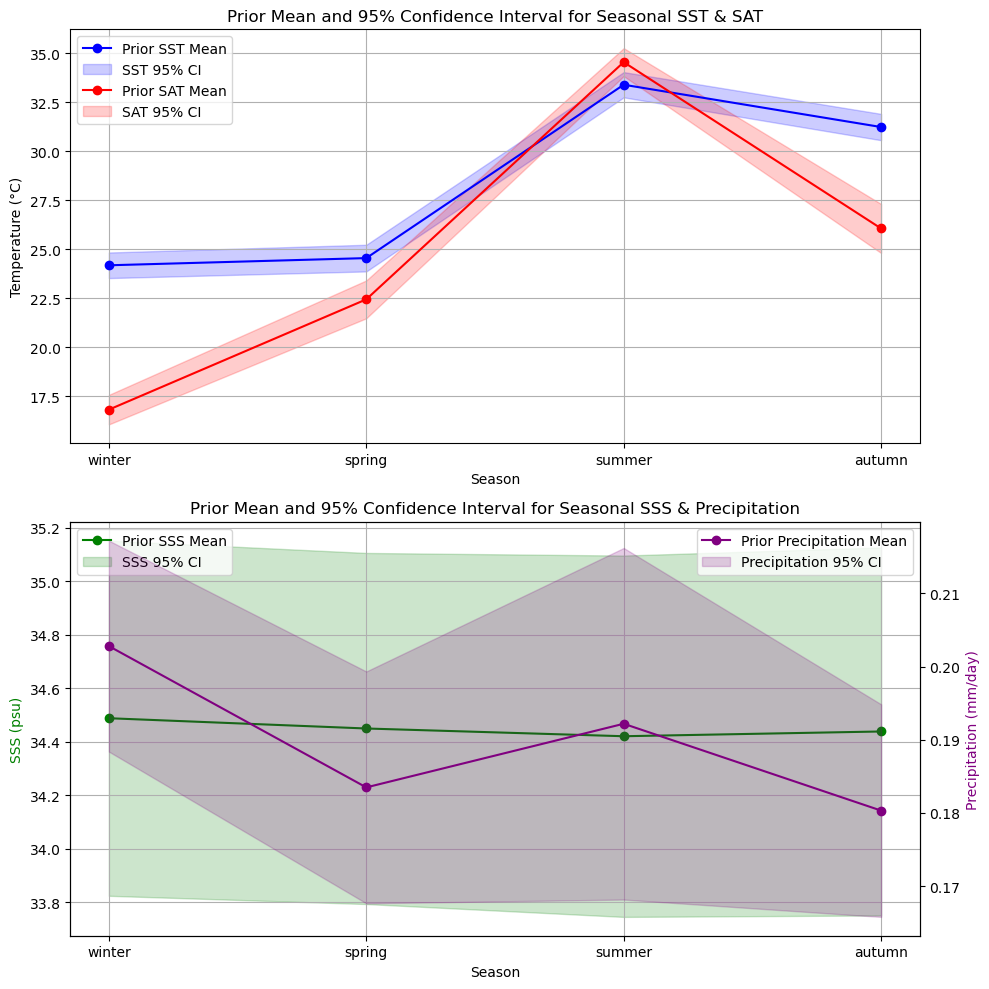

In [43]:
# Define the seasons, number of models, and scale for the x-axis
seasons = ["winter", "spring", "summer", "autumn"]
n_models_seasonal = len(Lutetian_models["Cell"])  # Find the total number of models
seasons_scale = np.arange(len(seasons)) + 1  # Create seasonal scale

# Create a 1x2 plotting grid
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Panel 1: Plot the prior distribution for SST and SAT
axes[0].plot(seasons_scale, mu_prior_SST_seasonal, label='Prior SST Mean', marker='o', color='b')
axes[0].fill_between(
    seasons_scale,
    mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='b', label='SST 95% CI'
)
axes[0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o', color='r')
axes[0].fill_between(
    seasons_scale,
    mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='r', label='SAT 95% CI'
)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST & SAT')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].legend()
axes[0].grid(True)

# Panel 2: Plot the prior distribution for SSS and precipitation
axes[1].plot(seasons_scale, mu_prior_SSS_seasonal, label='Prior SSS Mean', marker='o', color='g')
ax2 = axes[1].twinx()  # Create a secondary y-axis for precipitation
ax2.plot(seasons_scale, mu_prior_precip_seasonal, label='Prior Precipitation Mean', marker='o', color='purple')

# Add 95% confidence intervals for SSS
axes[1].fill_between(
    seasons_scale,
    mu_prior_SSS_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SSS_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='g', label='SSS 95% CI'
)

# Add 95% confidence intervals for precipitation
ax2.fill_between(
    seasons_scale,
    mu_prior_precip_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_precip_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='purple', label='Precipitation 95% CI'
)

axes[1].set_title('Prior Mean and 95% Confidence Interval for Seasonal SSS & Precipitation')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('SSS (psu)', color='g')
ax2.set_ylabel('Precipitation (mm/day)', color='purple')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')
axes[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Calculate the seasonal prior for model SST and SAT-derived D47 values with propagated uncertainty

In [44]:
# Set the weights of the data based on the standard errors
weights_seasonal_SST_D47 = 1 / Lutetian_models_seasonal[[f"{season}_SST_D47_SE" for season in seasons]] ** 2
weights_seasonal_SAT_D47 = 1 / Lutetian_models_seasonal[[f"{season}_SAT_D47_SE" for season in seasons]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_seasonal to match the headers of the D47 matrix later for multiplication
weights_seasonal_SST_D47.columns = [col.replace('_SST_D47_SE', '_SST_D47') for col in weights_seasonal_SST_D47.columns]
weights_seasonal_SAT_D47.columns = [col.replace('_SAT_D47_SE', '_SAT_D47') for col in weights_seasonal_SAT_D47.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_SST_D47_seasonal = np.array((Lutetian_models_seasonal[[f"{season}_SST_D47" for season in seasons]] * weights_seasonal_SST_D47).sum(axis = 0, skipna = True) / weights_seasonal_SST_D47.sum(axis = 0, skipna = True)) # Calculate weighted seasonal mean D47 values and convert to numpy array
mu_prior_SAT_D47_seasonal = np.array((Lutetian_models_seasonal[[f"{season}_SAT_D47" for season in seasons]] * weights_seasonal_SAT_D47).sum(axis = 0, skipna = True) / weights_seasonal_SAT_D47.sum(axis = 0, skipna = True)) # Calculate weighted seasonal mean D47 values and convert to numpy array

# Calculate simple (unweighted) mean for monthly d18Oc values
mu_prior_d18Oc_seasonal = np.array(Lutetian_models_seasonal[[f"{season}_d18Oc" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_precip_seasonal = np.array(Lutetian_models_seasonal[[f"{season}_precip" for season in seasons]].mean(axis=0, skipna=True))

# Decompose variance within and between model outcomes
model_variances_SST_D47 = Lutetian_models_seasonal[[f"{season}_SST_D47" for season in seasons]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_SAT_D47 = Lutetian_models_seasonal[[f"{season}_SAT_D47" for season in seasons]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances_SST_D47 = (Lutetian_models_seasonal[[f"{season}_SST_D47_SE" for season in seasons]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements
measurement_variances_SAT_D47 = (Lutetian_models_seasonal[[f"{season}_SAT_D47_SE" for season in seasons]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between seasons in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_seasonal_SST_D47 = np.cov(Lutetian_models_seasonal[[f"{season}_SST_D47" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_seasonal_SAT_D47 = np.cov(Lutetian_models_seasonal[[f"{season}_SAT_D47" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_seasonal_d18Oc = np.cov(Lutetian_models_seasonal[[f"{season}_d18Oc" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_seasonal_precip = np.cov(Lutetian_models_seasonal[[f"{season}_precip" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_D47_seasonal = cov_raw_seasonal_SST_D47.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_SAT_D47_seasonal = cov_raw_seasonal_SAT_D47.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_d18Oc_seasonal = cov_raw_seasonal_d18Oc.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_precip_seasonal = cov_raw_seasonal_precip.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_SST_D47_seasonal, np.diagonal(cov_raw_seasonal_SST_D47) + measurement_variances_SST_D47)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)
np.fill_diagonal(cov_prior_SAT_D47_seasonal, np.diagonal(cov_raw_seasonal_SAT_D47) + measurement_variances_SAT_D47)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SST_D47_seasonal_original, cov_prior_SST_D47_seasonal_original = mu_prior_SST_D47_seasonal.copy(), cov_prior_SST_D47_seasonal.copy()
mu_prior_SAT_D47_seasonal_original, cov_prior_SAT_D47_seasonal_original = mu_prior_SAT_D47_seasonal.copy(), cov_prior_SAT_D47_seasonal.copy()
mu_prior_d18Oc_seasonal_original, cov_prior_d18Oc_seasonal_original = mu_prior_d18Oc_seasonal.copy(), cov_raw_seasonal_d18Oc.copy()
mu_prior_precip_seasonal_original, cov_prior_precip_seasonal_original = mu_prior_precip_seasonal.copy(), cov_raw_seasonal_precip.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SST_D47_seasonal = np.sqrt(np.diag(cov_prior_SST_D47_seasonal))
std_prior_SAT_D47_seasonal = np.sqrt(np.diag(cov_prior_SAT_D47_seasonal))
std_prior_d18Oc_seasonal = np.sqrt(np.diag(cov_prior_d18Oc_seasonal))
std_prior_precip_seasonal = np.sqrt(np.diag(cov_prior_precip_seasonal))

print("mu_prior_SST_D47_seasonal:", mu_prior_SST_D47_seasonal)
print("std_prior_SST_D47_seasonal:", std_prior_SST_D47_seasonal)
print("mu_prior_SAT_D47_seasonal:", mu_prior_SAT_D47_seasonal)
print("std_prior_SAT_D47_seasonal:", std_prior_SAT_D47_seasonal)
print("mu_prior_d18Oc_seasonal:", mu_prior_d18Oc_seasonal)
print("std_prior_d18Oc_seasonal:", std_prior_d18Oc_seasonal)
print("mu_prior_precip_seasonal:", mu_prior_precip_seasonal)
print("std_prior_precip_seasonal:", std_prior_precip_seasonal)

mu_prior_SST_D47_seasonal: [0.59558454 0.5944782  0.5693298  0.57532305]
std_prior_SST_D47_seasonal: [0.00921641 0.00955641 0.00823186 0.00872053]
mu_prior_SAT_D47_seasonal: [0.61833332 0.60060654 0.56627243 0.58983039]
std_prior_SAT_D47_seasonal: [0.01118452 0.01354114 0.00895396 0.01698911]
mu_prior_d18Oc_seasonal: [-0.94610631 -1.04113704 -3.08652898 -2.58441643]
std_prior_d18Oc_seasonal: [0.48936498 0.526327   0.65431916 0.79321889]
mu_prior_precip_seasonal: [0.20279093 0.18348966 0.19218344 0.18032   ]
std_prior_precip_seasonal: [0.06518114 0.07164279 0.10863477 0.06570094]


## Plot the seasonal prior for model SST- and SAT-derived D47 values, d18Oc values and precipitation with propagated uncertainty

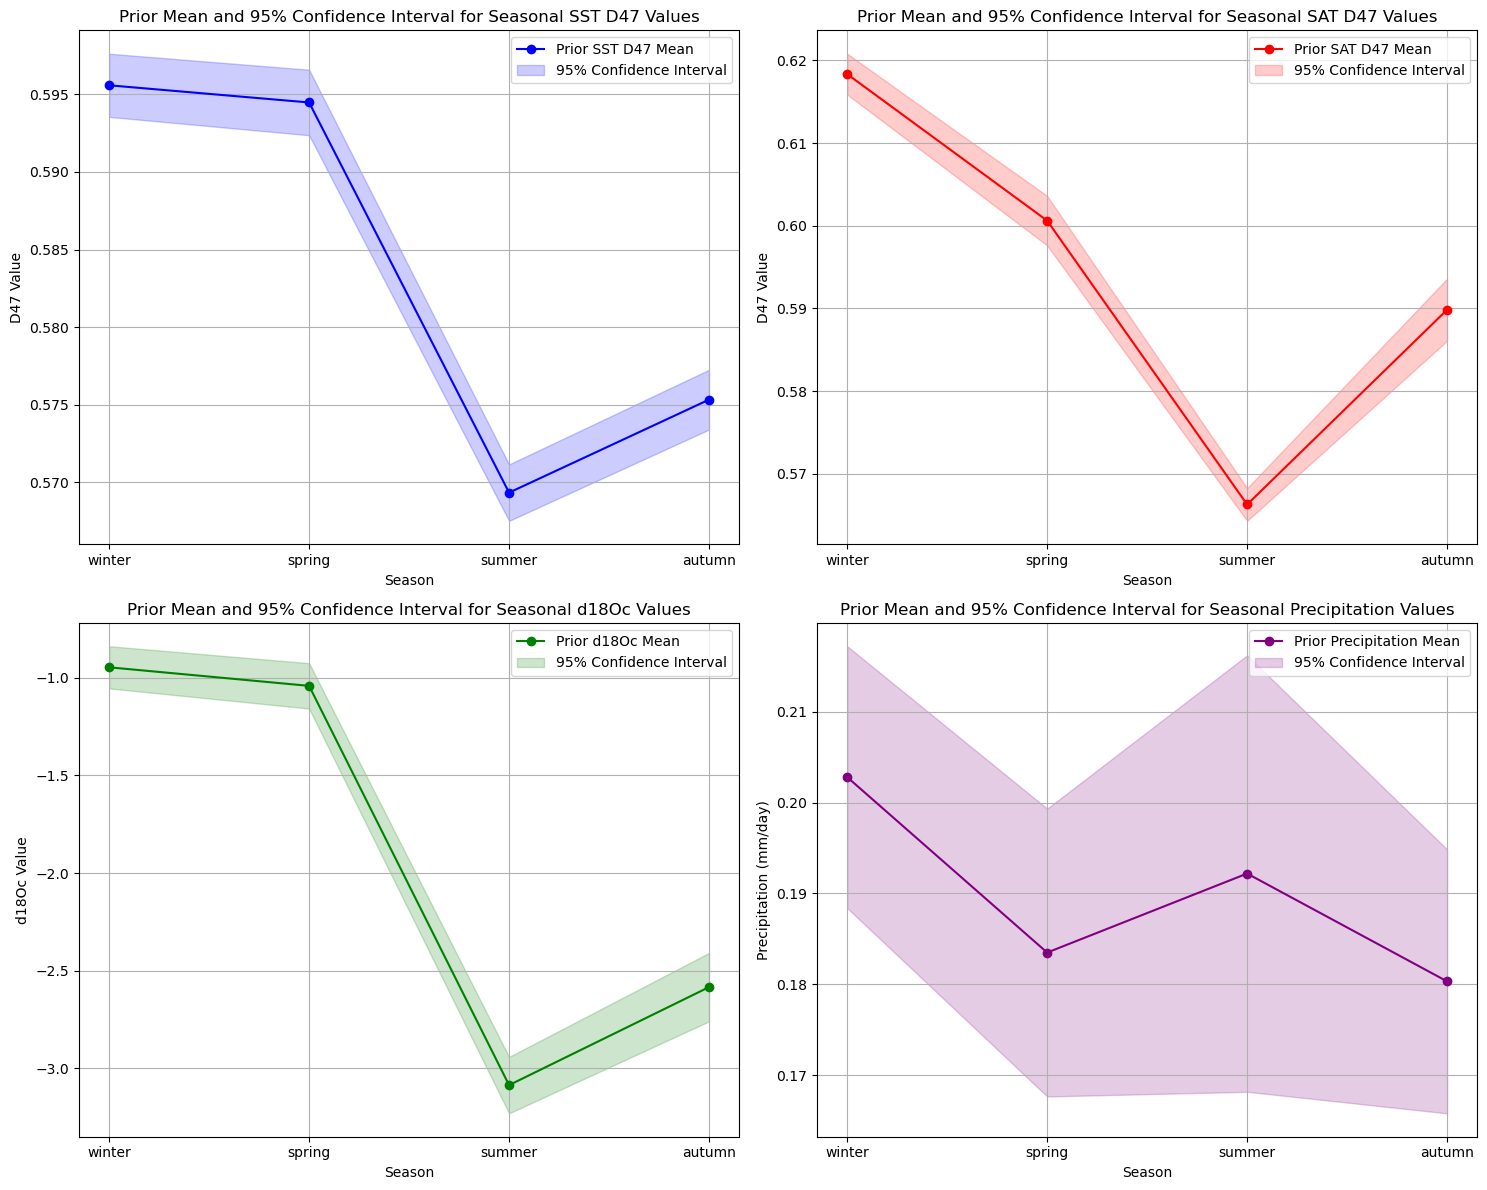

In [45]:
# Define the seasons, number of models, and scale for the x-axis
seasons = ["winter", "spring", "summer", "autumn"]
n_models_seasonal = len(Lutetian_models["Cell"])  # Find the total number of models (use monthly data because seasonal data has this column duplicated 3 times)
seasons_scale = np.arange(len(seasons)) + 1  # Create seasonal scale

# Create a 2x2 plotting grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Panel 1: Plot the prior distribution for SST D47 values
axes[0, 0].plot(seasons_scale, mu_prior_SST_D47_seasonal[:len(seasons)], label='Prior SST D47 Mean', marker='o', color='b')
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SST_D47_seasonal[:len(seasons)] - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal[:len(seasons)] + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='b', label='95% Confidence Interval'
)
axes[0, 0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST D47 Values')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('D47 Value')
axes[0, 0].set_xticks(seasons_scale)
axes[0, 0].set_xticklabels(seasons)
axes[0, 0].legend()
axes[0, 0].grid(True)

# Panel 2: Plot the prior distribution for SAT D47 values
axes[0, 1].plot(seasons_scale, mu_prior_SAT_D47_seasonal[:len(seasons)], label='Prior SAT D47 Mean', marker='o', color='r')
axes[0, 1].fill_between(
    seasons_scale,
    mu_prior_SAT_D47_seasonal[:len(seasons)] - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_D47_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_D47_seasonal[:len(seasons)] + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_D47_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='r', label='95% Confidence Interval'
)
axes[0, 1].set_title('Prior Mean and 95% Confidence Interval for Seasonal SAT D47 Values')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('D47 Value')
axes[0, 1].set_xticks(seasons_scale)
axes[0, 1].set_xticklabels(seasons)
axes[0, 1].legend()
axes[0, 1].grid(True)

# Panel 3: Plot the prior distribution for d18Oc
axes[1, 0].plot(seasons_scale, mu_prior_d18Oc_seasonal, label='Prior d18Oc Mean', marker='o', color='g')
axes[1, 0].fill_between(
    seasons_scale,
    mu_prior_d18Oc_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_d18Oc_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_d18Oc_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_d18Oc_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='g', label='95% Confidence Interval'
)
axes[1, 0].set_title('Prior Mean and 95% Confidence Interval for Seasonal d18Oc Values')
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('d18Oc Value')
axes[1, 0].set_xticks(seasons_scale)
axes[1, 0].set_xticklabels(seasons)
axes[1, 0].legend()
axes[1, 0].grid(True)

# Panel 4: Plot the prior distribution for precipitation
axes[1, 1].plot(seasons_scale, mu_prior_precip_seasonal, label='Prior Precipitation Mean', marker='o', color='purple')
axes[1, 1].fill_between(
    seasons_scale,
    mu_prior_precip_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_precip_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='purple', label='95% Confidence Interval'
)
axes[1, 1].set_title('Prior Mean and 95% Confidence Interval for Seasonal Precipitation Values')
axes[1, 1].set_xlabel('Season')
axes[1, 1].set_ylabel('Precipitation (mm/day)')
axes[1, 1].set_xticks(seasons_scale)
axes[1, 1].set_xticklabels(seasons)
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Calculate the seasonal covariance matrix for D47 values derived from SST and SAT values, d18Oc and precipitation

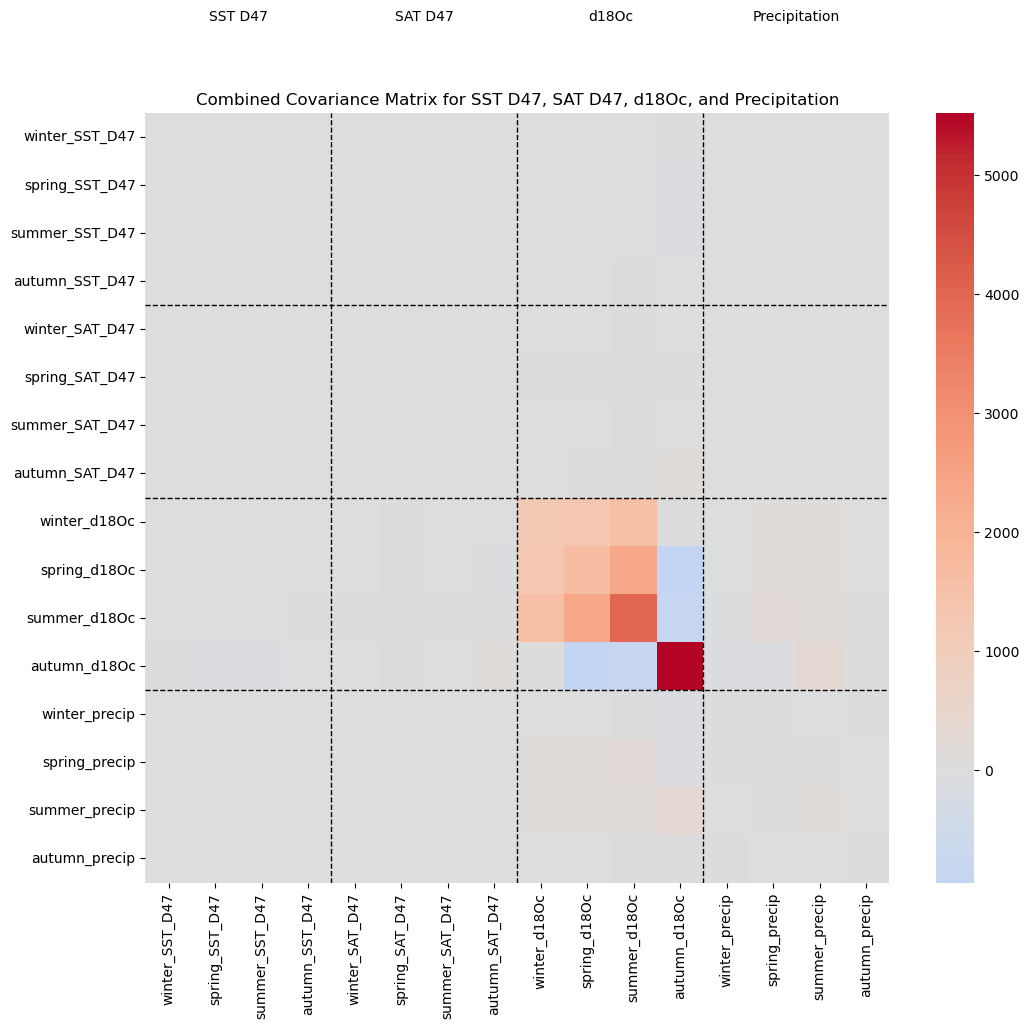

In [46]:
# Extract the relevant columns for SST, SAT D47, d18Oc, and precipitation
SST_D47_columns_seasonal = [f"{season}_SST_D47" for season in seasons]
SAT_D47_columns_seasonal = [f"{season}_SAT_D47" for season in seasons]
d18Oc_columns_seasonal = [f"{season}_d18Oc" for season in seasons]
precip_columns_seasonal = [f"{season}_precip" for season in seasons]

# Combine the relevant columns into a single dataframe
combined_data_seasonal = Lutetian_models_seasonal[
    SST_D47_columns_seasonal + SAT_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal
]

# Calculate the covariance matrix for the combined data
cov_combined_seasonal = np.cov(combined_data_seasonal.dropna(), rowvar=False)

# Extract the covariance matrices for each variable
cov_SST_D47_seasonal = cov_combined_seasonal[:len(seasons), :len(seasons)]
cov_SAT_D47_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), len(seasons):2*len(seasons)]
cov_d18Oc_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 2*len(seasons):3*len(seasons)]
cov_precip_seasonal = cov_combined_seasonal[3*len(seasons):, 3*len(seasons):]

# Extract the cross-covariance matrices
cross_cov_SST_SAT_D47_seasonal = cov_combined_seasonal[:len(seasons), len(seasons):2*len(seasons)]
cross_cov_SST_d18Oc_seasonal = cov_combined_seasonal[:len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SST_precip_seasonal = cov_combined_seasonal[:len(seasons), 3*len(seasons):]
cross_cov_SAT_d18Oc_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SAT_precip_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 3*len(seasons):]
cross_cov_d18Oc_precip_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 3*len(seasons):]

# Plot a heatmap of the combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    np.round(cov_combined_seasonal * 10**4, 1),  # Scale by 10^4 for better visualization and round values
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SST_D47_columns_seasonal + SAT_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal,
    yticklabels=SST_D47_columns_seasonal + SAT_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal
)

# Add titles to the axes per parameter
plt.axvline(x=len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SST_D47_columns_seasonal) / 2, -2, 'SST D47', ha='center', va='center', fontsize=10)
plt.text(len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) / 2, -2, 'SAT D47', ha='center', va='center', fontsize=10)
plt.text(len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal) / 2, -2, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal) + len(precip_columns_seasonal) / 2, -2, 'Precipitation', ha='center', va='center', fontsize=10)

plt.title("Combined Covariance Matrix for SST D47, SAT D47, d18Oc, and Precipitation")
plt.show()

## Plot normalized seasonal covariance matrix between D47 values of SST and SAT, d18Oc and precipitation

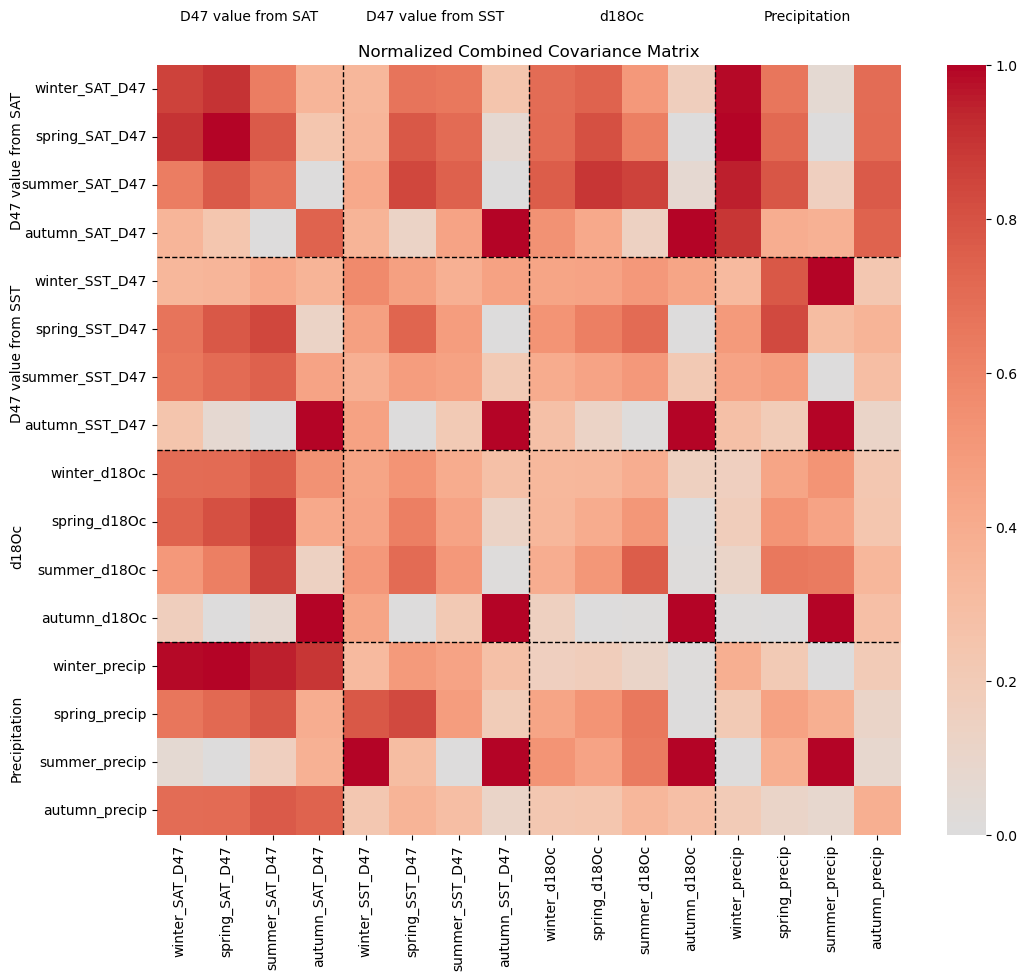

In [47]:
# Normalize each submatrix independently for better visualization
def normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)

# Extract the covariance matrices for SAT D47, SST D47, d18Oc, and precipitation
cov_SAT_D47_seasonal = cov_combined_seasonal[:len(seasons), :len(seasons)]
cov_SST_D47_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), len(seasons):2*len(seasons)]
cov_d18Oc_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 2*len(seasons):3*len(seasons)]
cov_precip_seasonal = cov_combined_seasonal[3*len(seasons):, 3*len(seasons):]

# Extract the cross-covariance matrices
cross_cov_SAT_SST_D47_seasonal = cov_combined_seasonal[:len(seasons), len(seasons):2*len(seasons)]
cross_cov_SAT_d18Oc_seasonal = cov_combined_seasonal[:len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SAT_precip_seasonal = cov_combined_seasonal[:len(seasons), 3*len(seasons):]
cross_cov_SST_d18Oc_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SST_precip_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 3*len(seasons):]
cross_cov_d18Oc_precip_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 3*len(seasons):]

# Normalize each submatrix
normalized_cov_SAT_D47_seasonal = normalize_matrix(cov_SAT_D47_seasonal)
normalized_cov_SST_D47_seasonal = normalize_matrix(cov_SST_D47_seasonal)
normalized_cov_d18Oc_seasonal = normalize_matrix(cov_d18Oc_seasonal)
normalized_cov_precip_seasonal = normalize_matrix(cov_precip_seasonal)

# Normalize each cross-covariance matrix
normalized_cross_cov_SAT_SST_D47_seasonal = normalize_matrix(cross_cov_SAT_SST_D47_seasonal)
normalized_cross_cov_SAT_d18Oc_seasonal = normalize_matrix(cross_cov_SAT_d18Oc_seasonal)
normalized_cross_cov_SAT_precip_seasonal = normalize_matrix(cross_cov_SAT_precip_seasonal)
normalized_cross_cov_SST_d18Oc_seasonal = normalize_matrix(cross_cov_SST_d18Oc_seasonal)
normalized_cross_cov_SST_precip_seasonal = normalize_matrix(cross_cov_SST_precip_seasonal)
normalized_cross_cov_d18Oc_precip_seasonal = normalize_matrix(cross_cov_d18Oc_precip_seasonal)

# Combine the normalized submatrices into a single normalized covariance matrix
normalized_cov_combined_seasonal = np.block([
    [normalized_cov_SAT_D47_seasonal, normalized_cross_cov_SAT_SST_D47_seasonal, normalized_cross_cov_SAT_d18Oc_seasonal, normalized_cross_cov_SAT_precip_seasonal],
    [normalized_cross_cov_SAT_SST_D47_seasonal.T, normalized_cov_SST_D47_seasonal, normalized_cross_cov_SST_d18Oc_seasonal, normalized_cross_cov_SST_precip_seasonal],
    [normalized_cross_cov_SAT_d18Oc_seasonal.T, normalized_cross_cov_SST_d18Oc_seasonal.T, normalized_cov_d18Oc_seasonal, normalized_cross_cov_d18Oc_precip_seasonal],
    [normalized_cross_cov_SAT_precip_seasonal.T, normalized_cross_cov_SST_precip_seasonal.T, normalized_cross_cov_d18Oc_precip_seasonal.T, normalized_cov_precip_seasonal]
])

# Plot the heatmap of the normalized combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    normalized_cov_combined_seasonal,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SAT_D47_columns_seasonal + SST_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal,
    yticklabels=SAT_D47_columns_seasonal + SST_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal
)

# Add titles to the axes per parameter
plt.axvline(x=len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SAT_D47_columns_seasonal) / 2, -1, 'D47 value from SAT', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) / 2, -1, 'D47 value from SST', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) / 2, -1, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) + len(precip_columns_seasonal) / 2, -1, 'Precipitation', ha='center', va='center', fontsize=10)

plt.text(-3, len(SAT_D47_columns_seasonal) / 2, 'D47 value from SAT', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-3, len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) / 2, 'D47 value from SST', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-3, len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) / 2, 'd18Oc', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-3, len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) + len(precip_columns_seasonal) / 2, 'Precipitation', ha='center', va='center', rotation=90, fontsize=10)

plt.title("Normalized Combined Covariance Matrix")
plt.show()

## Create combined seasonal state vector

In [48]:
# Combine the prior means of D47 and SAT into a single state vector
mu_prior_seasonal_combined = np.concatenate((mu_prior_SST_D47_seasonal, mu_prior_SAT_D47_seasonal, mu_prior_d18Oc_seasonal, mu_prior_precip_seasonal))

# Combine the covariance matrices of D47 values of SST and SAT, d18Oc and precipitation including the cross-covariance
cov_prior_seasonal_combined = cov_combined_seasonal.copy()

# OBSERVATIONS
## Load clumped data for updating
### Monthly data from Paris Basin Campanile giganteum paper (Van Horebeek et al. 2025)

In [49]:
# Load seasonal measurements and format them into a dictionary
# This is precompiled seasonal data per specimen and therefore does not come with a time uncertainty
Lutetian_seasonally_aggregated_data = pd.read_csv('Lutetian case/D47_season_data_calc.csv') # Load the data for seasonal averages
Lutetian_seasonally_aggregated_data_dict = Lutetian_seasonally_aggregated_data.to_dict('records') # Convert to dictionary with column headers as keys

# Add an entry for the time uncertainty (which is always zero in this case, because data is already aggregated monthly)
for record in Lutetian_seasonally_aggregated_data_dict:
    record["Season_err"] = 0 # Set the time uncertainty to zero
    record["D47_se"] = record["D47_SD"] / np.sqrt(record["count"]) # Calculate the standard error of the D47 value

print(Lutetian_seasonally_aggregated_data_dict[0]) # Print to check the structure of the data

{'Season': 'summer', 'Whorl...P.or.T': 'AW', 'X': 'AX', 'D47_mean': 0.589860492, 'D47_SD': 0.042653301, 'count': 62, 'd18O': -2.150527044, 'd18O_SD': 0.312787802, 'T': 27.892776, 'CL95': 0.010920335, 'CL95_T': 3.824099323, 'd18Osw': -0.27016391, 'DOY': 203.6572, 'Tmin': 24.20918351, 'Tmax': 31.71674359, 'dwmin': -1.11891794, 'dwmax': 0.610934613, 'Season_err': 0, 'D47_se': 0.005416974643977352}


### Raw data at the sample level

In [50]:
# Load measurements and format them into a dictionary
# These are the actual individual D47 measurements and ShellChron outcomes and thus come with a time uncertainty which can be propagated.
Lutetian_D47_data = pd.read_csv('Lutetian case/D47_sample_data_calc.csv') # Load data for individual D47 measurements and ShellChron outcomes
Lutetian_D47_data_dict = Lutetian_D47_data.to_dict('records') # Convert to dictionary with column headers as keys

# Add an entry for the time uncertainty (which is always zero in this case, because there is no time uncertainty in the raw data)
for record in Lutetian_D47_data_dict:
    record["Month_err"] = 0 # Set the time uncertainty to zero
    record["D47_SD"] = 0.029 # Assign external standard deviation to the D47 value (based on reproducibility of IAEA-C2 measurements)

print(Lutetian_D47_data_dict[0]) # Print to check the structure of the data

{'ID': 'AQ025', 'D': 794.0, 'Run': 508, 'Row': 27, 'Sample.intensity': 18607, 'X49.parameter': 0.038, 'D47_raw': -0.243, 'D47_SD': 0.029, 'D47_final': 0.568, 'Temperature': 34.1, 'd18O': -2.79, 'd13C': 0.67, 'Whorl': 'AQ', 'sample_nr': 25, 'Year': 2, 'season_manual': 'summer', 'd18O_SD': 0.1, 'day': 569.1204751, 'season_label': 3, 'T_d18O': 28.5856, 'DOY': 204.1204751, 'Season': 'summer', 'Month_err': 0}


## Summarize proxy data to seasonal bins

In [51]:
# Define the seasons for proxy data
proxy_seasons = {
    0: [12, 1, 2],
    1: [3, 4, 5],
    2: [6, 7, 8],
    3: [9, 10, 11]
}

# Define seasonal IDs based on season names
season_names = {
    0: "winter",
    1: "spring",
    2: "summer",
    3: "autumn"
}

# Add seasonal and monthly ID to the proxy data
for record in Lutetian_D47_data_dict:
    record["Season_err"] = 0 # Set the season error to zero
    month = math.ceil(record["DOY"] / 365 * 12) # Round up the modelled age to the nearest month
    if month == 0:
        month = 1 # Round exact 0 values up to 1 to prevent month indices of 0 (month should be in 1:12)
    record["month_score"] = month - 1 # Add the month score to the record (0-indexed)
    for season, months in proxy_seasons.items():
        if month in months:
            record["season_score"] = season
            break

for record in Lutetian_seasonally_aggregated_data_dict:
    record["Season_err"] = 0 # Set the season error to zero
    for season_score, season_name in season_names.items():
        if record["Season"] == season_name:
            record["season_score"] = season_score
            break

print(Lutetian_D47_data_dict[0]) # Print to check the structure of the data
print(Lutetian_seasonally_aggregated_data_dict[0]) # Print to check the structure of the data

{'ID': 'AQ025', 'D': 794.0, 'Run': 508, 'Row': 27, 'Sample.intensity': 18607, 'X49.parameter': 0.038, 'D47_raw': -0.243, 'D47_SD': 0.029, 'D47_final': 0.568, 'Temperature': 34.1, 'd18O': -2.79, 'd13C': 0.67, 'Whorl': 'AQ', 'sample_nr': 25, 'Year': 2, 'season_manual': 'summer', 'd18O_SD': 0.1, 'day': 569.1204751, 'season_label': 3, 'T_d18O': 28.5856, 'DOY': 204.1204751, 'Season': 'summer', 'Month_err': 0, 'Season_err': 0, 'month_score': 6, 'season_score': 2}
{'Season': 'summer', 'Whorl...P.or.T': 'AW', 'X': 'AX', 'D47_mean': 0.589860492, 'D47_SD': 0.042653301, 'count': 62, 'd18O': -2.150527044, 'd18O_SD': 0.312787802, 'T': 27.892776, 'CL95': 0.010920335, 'CL95_T': 3.824099323, 'd18Osw': -0.27016391, 'DOY': 203.6572, 'Tmin': 24.20918351, 'Tmax': 31.71674359, 'dwmin': -1.11891794, 'dwmax': 0.610934613, 'Season_err': 0, 'D47_se': 0.005416974643977352, 'season_score': 2}


## Prepare measurement and observation matrices

### Define a wrapped normal distribution to allow uncertainty in the time domain to flow around the year

In [52]:
# Function to calculate wrapped normal distribution weights
def wrapped_normal_pdf(x, mean, sd, num_bins):
    # Calculate the normal PDF for each bin
    pdf = stats.norm.pdf(x, loc = mean, scale = sd)
    # Wrap around the bins
    for i in range(1, num_bins):
        pdf += stats.norm.pdf(x + i * num_bins, loc = mean, scale = sd)
        pdf += stats.norm.pdf(x - i * num_bins, loc = mean, scale = sd)
    # Normalize the weights to ensure the sum equals 1
    pdf /= pdf.sum()
    return pdf

### Measurement matrix for season-averaged D47 and d18Oc values

In [53]:
# Extract measurements and uncertainties from the dictionary
D47_measurements_seasonal_averaged = [measurement["D47_mean"] for measurement in Lutetian_seasonally_aggregated_data_dict] # Extract the D47 values
d18Oc_measurements_seasonal_averaged = [measurement["d18O"] for measurement in Lutetian_seasonally_aggregated_data_dict] # Extract the d18Oc values
D47_measurements_seasonal_averaged_se = [measurement["D47_se"] ** 2 for measurement in Lutetian_seasonally_aggregated_data_dict] # Square the standard deviation to get the variance
d18Oc_measurements_seasonal_averaged_se = [measurement["d18O_SD"] ** 2 for measurement in Lutetian_seasonally_aggregated_data_dict] # Square the standard deviation to get the variance

# Create the measurement matrix Z
Z_seasonal_averaged = np.array(D47_measurements_seasonal_averaged + d18Oc_measurements_seasonal_averaged).reshape(-1, 1) # Combine D47 and d18Oc measurements into a single matrix

# Create the measurement uncertainty matrix R (diagonal matrix)
R_seasonal_averaged = np.diag(D47_measurements_seasonal_averaged_se + d18Oc_measurements_seasonal_averaged_se) # Combine the variances of D47 and d18Oc measurements into a single diagonal matrix

# Number of seasonally averaged measurements
N_measurements_seasonal_averaged = len(Z_seasonal_averaged) # Get the number of aggregated measurements

### Observation matrix for season-averaged D47 and d18Oc data from seasonally aggregated proxy measurements

In [54]:
# Create the observation matrix H for seasonal data based on seasonally aggregated data
H_seasonal_aggregated = np.zeros((N_measurements_seasonal_averaged, len(mu_prior_seasonal_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
for i, measurement in enumerate(Lutetian_seasonally_aggregated_data_dict + Lutetian_seasonally_aggregated_data_dict):
    if i < N_measurements_seasonal_averaged / 2: # For the first half of the measurements (D47 linked to SST)
        season_index = int(measurement["season_score"]) # Get the index of the season in the prior means
        H_seasonal_aggregated[i, season_index] = 1 # Index first 4 columns for D47 values (SST)
    else: # For the second half of the measurements (d18Oc linked to SSS)
        season_index = int(measurement["season_score"]) # Get the index of the season in the prior means
        H_seasonal_aggregated[i, season_index + 8] = 1 # Index columns 5:8 for d18Oc values (SSS)

print(H_seasonal_aggregated)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


### Measurement matrix for individual D47 values

In [55]:
# Extract measurements and uncertainties from the dictionary, skipping missing values
D47_measurements_individual = [measurement["D47_final"] for measurement in Lutetian_D47_data_dict if not pd.isna(measurement["D47_final"])] # Extract the D47 values
d18Oc_measurements_individual = [measurement["d18O"] for measurement in Lutetian_D47_data_dict if not pd.isna(measurement["d18O"])] # Extract the d18Oc values
D47_measurement_uncertainties_individual = [measurement["D47_SD"] ** 2 for measurement in Lutetian_D47_data_dict if not pd.isna(measurement["D47_final"])] # Square the standard deviation to get the variance
d18Oc_measurement_uncertainties_individual = [measurement["d18O_SD"] ** 2 for measurement in Lutetian_D47_data_dict if not pd.isna(measurement["d18O"])] # Square the standard deviation to get the variance

# Create the measurement matrix Z
Z_samples = np.array(D47_measurements_individual + d18Oc_measurements_individual).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_samples = np.diag(D47_measurement_uncertainties_individual + d18Oc_measurement_uncertainties_individual) # Combine the variances of D47 and d18Oc measurements into a single diagonal matrix

# Number of measurements
N_measurements_individual = len(Z_samples) # Get the number of measurements

### Observation matrix for monthly and seasonal D47 data from individual D47 values

In [ ]:
# Create the observation matrix H for monthly data based on individual measurements
H_monthly = np.zeros((N_measurements_individual, len(mu_prior_monthly_combined)))
H_seasonal = np.zeros((N_measurements_individual, len(mu_prior_seasonal_combined)))

# Fill the first part of the observation matrix H with ones at the positions corresponding to the D47 measurements, ignoring NaN values
for i, measurement in enumerate([m for m in Lutetian_D47_data_dict if not pd.isna(m["D47_final"])]):
    time_index = int(measurement["season_score"])
    H_seasonal[i, time_index] = 1  # Indexing the first set of columns (1:4) for SST_D47
    H_monthly[i, time_index] = 1  # Indexing the first set of columns (1:12) for SST_D47

# Fill the second part of the observation matrix H with ones at the positions corresponding to the d18Oc measurements, ignoring NaN values
for i, measurement in enumerate([m for m in Lutetian_D47_data_dict if not pd.isna(m["d18O"])]):
    time_index = int(measurement["season_score"])
    H_seasonal[i + len(D47_measurements_individual), time_index + 8] = 1  # Indexing the third column block (8:12) for d18Oc
    H_monthly[i + len(D47_measurements_individual), time_index + 24] = 1  # Indexing the third column block (25:36) for d18Oc

print(H_monthly)
print(H_seasonal)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### TO DO: Define observation matrices with time uncertainty

In [59]:
# FIXME

# DEFINE UPDATING FUNCTIONS

## Create updating function (Kalman filter)
- Include updating of second variable (SAT) through cross-covariance
- Use block updating

Input:
- Prior means (mu_prior)
- Prior covariance matrix (P)
- Observation matrix (H)
- Measurement matrix (Z)
- Uncertainty matrix (R)

Output:
- Posterior means (mu_post)
- Posterior covariance matrix (P_post)

In [98]:
def kalman_update_block(
    mu_prior: np.ndarray,
    cov_prior: np.ndarray,
    Z: np.ndarray,
    R: np.ndarray,
    H: np.ndarray,
    debug_print: bool = False
):
    """
    Perform a Kalman update step for a block of observations.

    Parameters:
    mu_prior (np.ndarray): The prior mean vector.
    cov_prior (np.ndarray): The prior covariance matrix.
    Z (np.ndarray): The measurement matrix.
    R (np.ndarray): The measurement noise covariance matrix.
    H (np.ndarray): The observation matrix.
    debug_print (bool): If True, print debug statements.

    Returns:
    mu_posterior (np.ndarray): The posterior mean vector.
    cov_posterior (np.ndarray): The posterior covariance matrix.
    """
    if debug_print:
        # Print shapes of key variables for debugging
        print("Shape of cov_prior:", cov_prior.shape)
        print("Shape of H:", H.shape)
        print("Shape of R:", R.shape)
        print("Shape of mu_prior:", mu_prior.shape)
        print("Shape of Z:", Z.shape)

    # Compute the Kalman gain
    K = cov_prior @ H.T @ np.linalg.inv(H @ cov_prior @ H.T + R)
    if debug_print:
        print("Shape of K:", K.shape)

    # In-between steps for debugging
    Y_hat = H @ mu_prior  # Compute the predicted observation
    if debug_print:
        print("Shape of Y_hat:", Y_hat.shape)
    innovation = Z - Y_hat.reshape(-1, 1)  # Compute the innovation
    if debug_print:
        print("Shape of innovation:", innovation.shape)
    kalman_gain = K @ innovation  # Compute the Kalman gain
    if debug_print:
        print("Shape of kalman_gain:", kalman_gain.shape)

    # Update the posterior mean estimate
    mu_posterior = mu_prior + kalman_gain.flatten()

    # Update the posterior covariance estimate
    cov_posterior = cov_prior - K @ H @ cov_prior

    return mu_posterior, cov_posterior

## Create function to track the statistics of the likelihood (combining just the reconstruction data)

In [99]:
# # ORIGINAL FUNCTION

# # Create function to keep track of the likelihood statistics and data

# # Suppress FutureWarning
# warnings.simplefilter(action = 'ignore', category = FutureWarning)

# def likelihood_statistics(
#     weighted_sum,
#     effective_weights_total,
#     n_update,
#     data_library,
#     measurement,
#     timestamp,
#     timestamp_sd,
#     Variable_name = "Variable_name",
#     Variable_name_SD = "Variable_name_SD"
# ):
#     """
#     Incrementally updates the likelihood statistics for seasonal data.

#     Parameters:
#     - weighted_sum: list
#         List tracking the mean times the effective weight for each time bin.
#     - effective_weights_total: list
#         List tracking the sum of effective weights for each time bin.
#     - n_update: list
#         List tracking the number of datapoints for each time bin.
#     - data_library: dict
#         Dictionary tracking individual data points and their uncertainties.
#     - measurement: dict
#         A single measurement containing seasonal and temperature data.
#     - timestamp: str
#         Key in the measurement dictionary for the timestamp (0-based index).
#     - timestamp_sd: float
#         Standard deviation of uncertainty in the timestamp.
#     - Variable_name: str
#         Key in the measurement dictionary for the time bin (e.g. month or season).
#     - Variable_name_SD: str
#         Key in the measurement dictionary for the standard deviation on the age model (e.g. month or season).
#     """
#     if timestamp in measurement and Variable_name in measurement and Variable_name_SD in measurement:
#         time = measurement[timestamp]
#         time_sd = measurement[timestamp_sd]
#         data_val = measurement[Variable_name]
#         data_sd = measurement[Variable_name_SD]
        
#         # print(time, time_sd, data_val, data_sd) # Print to check the values

#         # Check if the data is valid
#         if not np.isnan(data_val) and not np.isnan(data_sd):
#             # Calculate the weight (inverse of variance)
#             weight = 1 / (data_sd ** 2)
                        
#             # Determine the number of bins
#             num_bins = len(weighted_sum)
#             bin_indices = np.arange(num_bins, dtype = np.float64)
            
#             # Calculate the probability density for each bin
#             if time_sd == 0: # Catch cases where the time uncertainty is zero (or unknown)
#                 probabilities = np.zeros(num_bins, dtype = np.float64)
#                 bin_index = int(time) % num_bins  # Ensure the bin index is within range
#                 probabilities[bin_index] = 1 # Set the probability to 1 for the correct bin
#             else:
#                 probabilities = stats.norm.pdf(bin_indices, loc = time, scale = time_sd) # For non-zero time uncertainty, use a normal distribution
#                 probabilities /= probabilities.sum()  # Normalize to ensure the sum of probabilities is 1
            
#             for i, prob in enumerate(probabilities): # Loop over all possible bin numbers in the probability vector
#                 bin_index = i % num_bins  # Wrap around to the first bin if it overflows
                
#                 # Update the weighted sums and sample count
#                 effective_weight = weight * prob
#                 if weighted_sum[bin_index] is None:
#                     weighted_sum[bin_index] = 0
#                     effective_weights_total[bin_index] = 0
#                 weighted_sum[bin_index] = weighted_sum[bin_index] + data_val * effective_weight
#                 effective_weights_total[bin_index] = effective_weights_total[bin_index] + effective_weight
            
#             n_update[int(time) % num_bins] = n_update[int(time) % num_bins] + 1 # update sample number per bin

#             # Track individual data points and their uncertainties
#             if time not in data_library:
#                 data_library[int(time)] = []  # Initialize the list for a new time bin
#             data_library[int(time)].append((time_sd, data_val, data_sd))
    
#     return weighted_sum, effective_weights_total, n_update, data_library # Return the updated values

In [100]:
# UPDATED UPDATING SCRIPT TO ACCOMMODATE MULTIPLE VARIABLES

# Create function to keep track of the likelihood statistics and data

def likelihood_statistics_multi(
    weighted_sum,
    effective_weights_total,
    n_update,
    data_library,
    measurement,
    timestamp,
    timestamp_sd,
    Variable_names = ["Variable_name1", "Variable_name2"],
    Variable_names_SDs = ["Variable_name_SD1", "Variable_name_SD2"]
):
    """
    Incrementally updates the likelihood statistics for seasonal data.

    Parameters:
    - weighted_sum: list
        List tracking the mean times the effective weight for each time bin and variable.
    - effective_weights_total: list
        List tracking the sum of effective weights for each time bin and variable.
    - n_update: list
        List tracking the number of datapoints for each time bin and variable.
    - data_library: dict
        Dictionary tracking individual data points and their uncertainties.
    - measurement: dict
        A single measurement containing data on multiple variables.
    - timestamp: str
        Key in the measurement dictionary for the timestamp (0-based index).
    - timestamp_sd: float
        Standard deviation of uncertainty in the timestamp.
    - Variable_name: list of str
        Key in the measurement dictionary for the variables (e.g. d18Os, D47).
    - Variable_name_SD: list of str
        Key in the measurement dictionary for the standard deviation on the variables (e.g. d18Os, D47).
    """
    # Check if at least one combination of variable name and its SD is present in the measurement
    found = False
    for var_name, var_sd_name in zip(Variable_names, Variable_names_SDs):
        if var_name in measurement and var_sd_name in measurement:
            found = True
            break

    if timestamp in measurement and found:
        # Extract the time and data values from the measurement
        time = measurement[timestamp]
        time_sd = measurement[timestamp_sd]
        # Loop through all variable/SD pairs
        for var_name, var_sd_name in zip(Variable_names, Variable_names_SDs):
            if var_name in measurement and var_sd_name in measurement:
                data_val = measurement[var_name]
                data_sd = measurement[var_sd_name]
                
                # Check if the data is valid
                if not np.isnan(data_val) and not np.isnan(data_sd):
                    # Calculate the weight (inverse of variance)
                    weight = 1 / (data_sd ** 2)

                    # Determine the number of bins
                    num_bins_seasonal = int(len(weighted_sum) / len(Variable_names))
                    # Ensure num_bins_seasonal is an integer
                    bin_indices = np.arange(num_bins_seasonal, dtype=np.float64)

                    # Calculate the probability density for each bin
                    if time_sd == 0:  # Catch cases where the time uncertainty is zero (or unknown)
                        probabilities = np.zeros(num_bins_seasonal, dtype=np.float64)
                        bin_index = int(time) % num_bins_seasonal  # Ensure the bin index is within range
                        probabilities[bin_index] = 1  # Set the probability to 1 for the correct bin
                    else:
                        probabilities = stats.norm.pdf(bin_indices, loc=time, scale=time_sd)  # For non-zero time uncertainty, use a normal distribution
                        probabilities /= probabilities.sum()  # Normalize to ensure the sum of probabilities is 1

                    for i, prob in enumerate(probabilities):  # Loop over all possible bin numbers in the probability vector
                        bin_index = i % num_bins_seasonal  # Wrap around to the first bin if it overflows

                        # Update the weighted sums and sample count
                        effective_weight = weight * prob
                        var_idx = Variable_names.index(var_name)  # Find the index of the variable
                        idx = int(var_idx * num_bins_seasonal + bin_index)  # Unique index for (variable, bin)
                        if weighted_sum[idx] is None:
                            weighted_sum[idx] = 0
                            effective_weights_total[idx] = 0
                        weighted_sum[idx] = weighted_sum[idx] + data_val * effective_weight
                        effective_weights_total[idx] = effective_weights_total[idx] + effective_weight

                    # Update n_update for the correct variable and bin
                    var_idx = Variable_names.index(var_name) # Find the index of the variable
                    n_update[var_idx * num_bins_seasonal + (int(time) % num_bins_seasonal)] += 1  # update sample number per bin and variable

                    # Track individual data points and their uncertainties
                    key = (var_name, int(time)) # Store individual data points in a dictionary with (variable, time) as key
                    if key not in data_library:
                        data_library[key] = []  # Initialize the list for a new (time, var_name) pair
                    data_library[key].append((time_sd, data_val, data_sd))
    return weighted_sum, effective_weights_total, n_update, data_library # Return the updated values

# EXECUTE UPDATING FUNCTIONS - SEASONAL

## Update seasonal prior with aggregated data
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen and per season

In [101]:
# Apply Kalman function to update the prior with seasonal data including updating the prec estimates
# Update the seasonal D47 and prec prior with all measurements using block updating
seasonal_data = {} # Keep track of datapoints per season
n_update_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_seasonal_aggregated, cov_post_seasonal_aggregated = kalman_update_block(
    mu_prior_seasonal_combined,
    cov_prior_seasonal_combined,
    Z_seasonally_aggregated,
    R_seasonally_aggregated,
    H_seasonal_aggregated
)

# Extract the updated D47 and prec values from the combined state vector
mu_post_D47_seasonal_aggregated = mu_post_seasonal_aggregated[:len(mu_prior_D47_seasonal)]
mu_post_prec_seasonal_aggregated = mu_post_seasonal_aggregated[len(mu_prior_D47_seasonal):]

# Extract the updated covariance matrices for D47 and prec
cov_post_D47_seasonal_aggregated = cov_post_seasonal_aggregated[:len(mu_prior_D47_seasonal), :len(mu_prior_D47_seasonal)]
cov_post_prec_seasonal_aggregated = cov_post_seasonal_aggregated[len(mu_prior_D47_seasonal):, len(mu_prior_D47_seasonal):]

for measurement in Lutetian_seasonally_aggregated_data_dict: # Loop over measurements    
    # Track and update likelihood statistics
    weighted_sum_seasonal_aggregated, effective_weights_total_seasonal_aggregated, n_update_seasonal_aggregated, seasonal_data = likelihood_statistics_multi(
        weighted_sum_seasonal_aggregated,
        effective_weights_total_seasonal_aggregated,
        n_update_seasonal_aggregated,
        seasonal_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Season_err",
        Variable_name = "D47_mean",
        Variable_name_SD = "D47_se"
    )

# Normalize the weighted_sum_seasonal_aggregated to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonal_aggregated to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonal_aggregated)):
    if effective_weights_total_seasonal_aggregated[i] is not None and effective_weights_total_seasonal_aggregated[i] != 0:
        mu_likelihood_seasonal_aggregated[i] = weighted_sum_seasonal_aggregated[i] / effective_weights_total_seasonal_aggregated[i]
        std_likelihood_seasonal_aggregated[i] = np.sqrt(1 / effective_weights_total_seasonal_aggregated[i])

    print(f"Season: {seasons[i]}")
    print(f"Weighted Average D47: {mu_likelihood_seasonal_aggregated[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonal_aggregated[i]}")
    print(f"Number of Data Points: {n_update_seasonal_aggregated[i]}\n")

print("Original Prior Mean D47 Seasonal:\n", mu_prior_D47_seasonal_original)
print("Original Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_D47_seasonal_original)))
print("Updated Prior Mean D47 Seasonal:\n", mu_post_D47_seasonal_aggregated)
print("Updated Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_post_D47_seasonal_aggregated)))
print("Original Prior Mean precipitation Seasonal:\n", mu_prior_prec_seasonal_original)
print("Original Prior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_prior_prec_seasonal_original)))
print("Updated Prior Mean precipitation Seasonal:\n", mu_post_prec_seasonal_aggregated)
print("Updated Prior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_post_prec_seasonal_aggregated)))

NameError: name 'mu_prior_D47_seasonal' is not defined

### Plot seasonal posterior in D47 domain

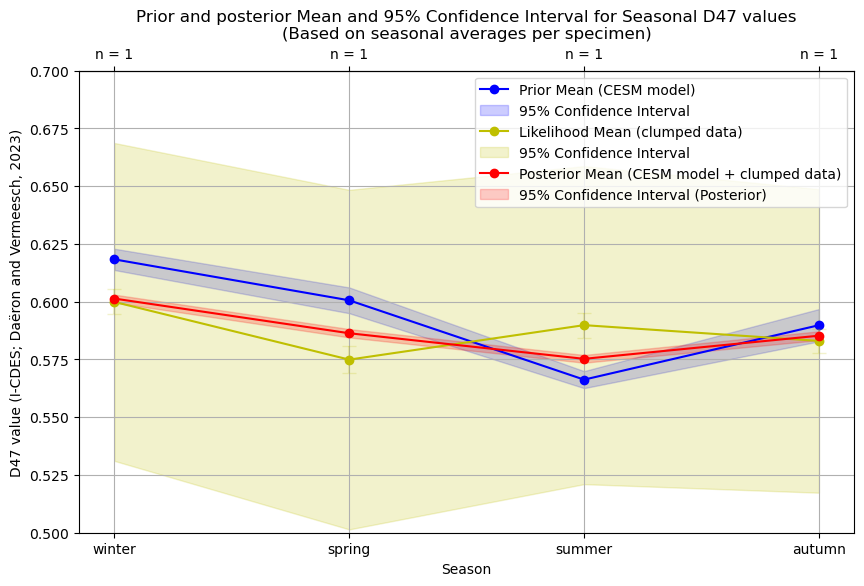

In [ ]:
# Plot the updated seasonal posterior
std_post_D47_seasonal_aggregated = np.sqrt(np.diag(cov_post_D47_seasonal_aggregated))
std_prior_D47_seasonal_original = np.sqrt(np.diag(cov_prior_D47_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_original, label = 'Prior Mean (CESM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal_aggregated, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal_aggregated - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated) * std_likelihood_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated),
    mu_likelihood_seasonal_aggregated + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated) * std_likelihood_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Lutetian_seasonally_aggregated_data_dict: # Loop over measurements
    plt.plot(measurement["season_score"] + 1, measurement["D47_mean"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season_score"] + 1, measurement["D47_mean"], yerr = measurement["D47_se"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal_aggregated])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_D47_seasonal_aggregated, label = 'Posterior Mean (CESM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_D47_seasonal_aggregated - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_post_D47_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    mu_post_D47_seasonal_aggregated + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_post_D47_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal D47 values\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.5, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update seasonal prior with individual datapoints
* Aggregate data and model outcomes in 4 seasons based on individual D47 datapoints
* No sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [ ]:
# Apply Kalman function to update the prior with seasonal data including updating the precipitation estimates
# Update the seasonal D47 and precipitation prior with all measurements using block updating
seasonal_data = {} # Keep track of datapoints per season
n_update_seasonal = mu_prior_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonal = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonal = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonal = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonal = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_seasonal, cov_post_seasonal = kalman_update_block(
    mu_prior_seasonal_combined,
    cov_prior_seasonal_combined,
    Z_samples,
    R_samples,
    H_seasonal
)

# Extract the updated D47 and precipitation values from the combined state vector
mu_post_D47_seasonal = mu_post_seasonal[:len(mu_prior_D47_seasonal)]
mu_post_prec_seasonal = mu_post_seasonal[len(mu_prior_D47_seasonal):]

# Extract the updated covariance matrices for D47 and prec
cov_post_D47_seasonal = cov_post_seasonal[:len(mu_prior_D47_seasonal), :len(mu_prior_D47_seasonal)]
cov_post_prec_seasonal = cov_post_seasonal[len(mu_prior_D47_seasonal):, len(mu_prior_D47_seasonal):]

for measurement in Lutetian_D47_data_dict: # Loop over measurements    
    # Track and update likelihood statistics
    weighted_sum_seasonal, effective_weights_total_seasonal, n_update_seasonal, seasonal_data = likelihood_statistics_multi(
        weighted_sum_seasonal,
        effective_weights_total_seasonal,
        n_update_seasonal,
        seasonal_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Season_err",
        Variable_name = "D47_final",
        Variable_name_SD = "D47_SD"
    )

# Normalize the weighted_sum_seasonal to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonal to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonal)):
    if effective_weights_total_seasonal[i] is not None and effective_weights_total_seasonal[i] != 0:
        mu_likelihood_seasonal[i] = weighted_sum_seasonal[i] / effective_weights_total_seasonal[i]
        std_likelihood_seasonal[i] = np.sqrt(1 / effective_weights_total_seasonal[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonal[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonal[i]}")
    print(f"Number of Data Points: {n_update_seasonal[i]}\n")

print("Original Prior Mean D47 Seasonal:\n", mu_prior_D47_seasonal_original)
print("Original Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_D47_seasonal_original)))
print("Updated Prior Mean D47 Seasonal:\n", mu_post_D47_seasonal)
print("Updated Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_post_D47_seasonal)))
print("Original Prior Mean seasonal precipitation:\n", mu_prior_prec_seasonal_original)
print("Original Prior Standard Deviation seasonal precipitation:\n", np.sqrt(np.diag(cov_prior_prec_seasonal_original)))
print("Updated Prior Mean seasonal precipitation:\n", mu_post_prec_seasonal)
print("Updated Prior Standard Deviation seasonal precipitation:\n", np.sqrt(np.diag(cov_post_prec_seasonal)))

Shape of cov_prior: (8, 8)
Shape of H: (168, 8)
Shape of R: (168, 168)
Shape of mu_prior: (8,)
Shape of Z: (168, 1)
Shape of K: (8, 168)
Shape of Y_hat: (168,)
Shape of innovation: (168, 1)
Shape of kalman_gain: (8, 1)
Likelihood statistics:
Month: 1
Weighted Average D47: 0.5993461538461538
Aggregated Uncertainty (D47_sd): 0.005687367919007337
Number of Data Points: 26.0

Month: 2
Weighted Average D47: 0.5812750000000003
Aggregated Uncertainty (D47_sd): 0.004585302607244152
Number of Data Points: 40.0

Month: 3
Weighted Average D47: 0.5897903225806456
Aggregated Uncertainty (D47_sd): 0.003683003683005526
Number of Data Points: 62.0

Month: 4
Weighted Average D47: 0.5846500000000002
Aggregated Uncertainty (D47_sd): 0.004585302607244152
Number of Data Points: 40.0

Original Prior Mean D47 Seasonal:
 [0.61833332 0.60060654 0.56627243 0.58983039]
Original Prior Standard Deviation D47 Seasonal:
 [0.01118452 0.01354114 0.00895396 0.01698911]
Updated Prior Mean D47 Seasonal:
 [0.60201744 0.58

C:\Users\nwi213\AppData\Local\Temp\ipykernel_21416\470237694.py:62: RuntimeWarning: invalid value encountered in sqrt
  print("Updated Prior Standard Deviation seasonal precipitation:\n", np.sqrt(np.diag(cov_post_prec_seasonal)))


### Plot seasonal posterior in D47 domain

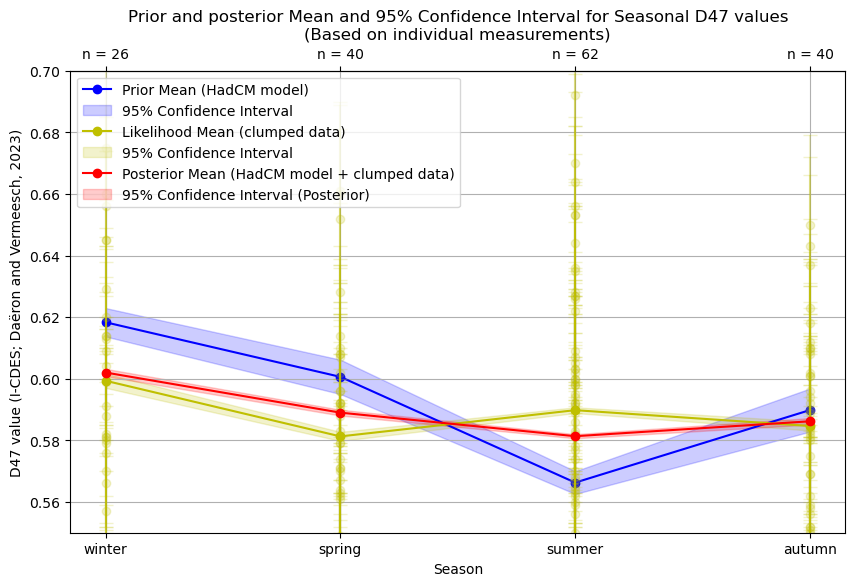

In [ ]:
# Plot the updated seasonal posterior
std_post_D47_seasonal = np.sqrt(np.diag(cov_post_D47_seasonal))
std_prior_D47_seasonal_original = np.sqrt(np.diag(cov_prior_D47_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_original, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Lutetian_D47_data_dict: # Loop over measurements
    plt.plot(measurement["season_score"] + 1, measurement["D47_final"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season_score"] + 1, measurement["D47_final"], yerr = measurement["D47_SD"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_D47_seasonal, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_D47_seasonal - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_D47_seasonal / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_post_D47_seasonal + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_D47_seasonal / np.sqrt(n_update_seasonal + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal D47 values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

# EXECUTE UPDATING FUNCTIONS - MONTHLY

## Update monthly prior with individual datapoints
* Aggregate data and model outcomes in 12 seasons based on individual D47 datapoints
* No sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [ ]:
# Apply Kalman function to update the prior with monthly data including updating the precipitation estimates
# Update the monthly D47 and precipitation prior with all measurements using block updating
monthly_data = {} # Keep track of datapoints per season
n_update_monthly = mu_prior_D47_monthly * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthly = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthly = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthly = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthly = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with monthly data using the Kalman filter in block updating form
mu_post_monthly, cov_post_monthly = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_samples,
    R_samples,
    H_monthly
)

# Extract the updated D47 and precipitation values from the combined state vector
mu_post_D47_monthly = mu_post_monthly[:len(mu_prior_D47_monthly)]
mu_post_prec_monthly = mu_post_monthly[len(mu_prior_D47_monthly):]

# Extract the updated covariance matrices for D47 and prec
cov_post_D47_monthly = cov_post_monthly[:len(mu_prior_D47_monthly), :len(mu_prior_D47_monthly)]
cov_post_prec_monthly = cov_post_monthly[len(mu_prior_D47_monthly):, len(mu_prior_D47_monthly):]

for measurement in Lutetian_D47_data_dict: # Loop over measurements    
    # Track and update likelihood statistics
    weighted_sum_monthly, effective_weights_total_monthly, n_update_monthly, monthly_data = likelihood_statistics_multi(
        weighted_sum_monthly,
        effective_weights_total_monthly,
        n_update_monthly,
        monthly_data,
        measurement,
        timestamp = "month_score",
        timestamp_sd = "Month_err",
        Variable_name = "D47_final",
        Variable_name_SD = "D47_SD"
    )

# Normalize the weighted_sum_monthly to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_monthly)):
    if effective_weights_total_monthly[i] is not None and effective_weights_total_monthly[i] != 0:
        mu_likelihood_monthly[i] = weighted_sum_monthly[i] / effective_weights_total_monthly[i]
        std_likelihood_monthly[i] = np.sqrt(1 / effective_weights_total_monthly[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_monthly[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_monthly[i]}")
    print(f"Number of Data Points: {n_update_monthly[i]}\n")

print("Original Prior Mean D47 monthly:\n", mu_prior_D47_monthly_original)
print("Original Prior Standard Deviation D47 monthly:\n", np.sqrt(np.diag(cov_prior_D47_monthly_original)))
print("Updated Prior Mean D47 monthly:\n", mu_post_D47_monthly)
print("Updated Prior Standard Deviation D47 monthly:\n", np.sqrt(np.diag(cov_post_D47_monthly)))
print("Original Prior Mean monthly precipitation:\n", mu_prior_prec_monthly_original)
print("Original Prior Standard Deviation monthly precipitation:\n", np.sqrt(np.diag(cov_prior_prec_monthly_original)))
print("Updated Prior Mean monthly precipitation:\n", mu_post_prec_monthly)
print("Updated Prior Standard Deviation monthly precipitation:\n", np.sqrt(np.diag(cov_post_prec_monthly)))

Shape of cov_prior: (24, 24)
Shape of H: (168, 24)
Shape of R: (168, 168)
Shape of mu_prior: (24,)
Shape of Z: (168, 1)
Shape of K: (24, 168)
Shape of Y_hat: (168,)
Shape of innovation: (168, 1)
Shape of kalman_gain: (24, 1)
Likelihood statistics:
Month: 1
Weighted Average D47: 0.6315000000000001
Aggregated Uncertainty (D47_sd): 0.0145
Number of Data Points: 4.0

Month: 2
Weighted Average D47: 0.5964285714285713
Aggregated Uncertainty (D47_sd): 0.01096096971726759
Number of Data Points: 7.0

Month: 3
Weighted Average D47: 0.6064999999999998
Aggregated Uncertainty (D47_sd): 0.01025304832720494
Number of Data Points: 8.0

Month: 4
Weighted Average D47: 0.0
Aggregated Uncertainty (D47_sd): 0.0
Number of Data Points: 0.0

Month: 5
Weighted Average D47: 0.5749687500000001
Aggregated Uncertainty (D47_sd): 0.0051265241636024705
Number of Data Points: 32.0

Month: 6
Weighted Average D47: 0.5925624999999998
Aggregated Uncertainty (D47_sd): 0.0072499999999999995
Number of Data Points: 16.0

Mont

C:\Users\nwi213\AppData\Local\Temp\ipykernel_21416\280848438.py:62: RuntimeWarning: invalid value encountered in sqrt
  print("Updated Prior Standard Deviation monthly precipitation:\n", np.sqrt(np.diag(cov_post_prec_monthly)))


### Plot monthly posterior in D47 domain

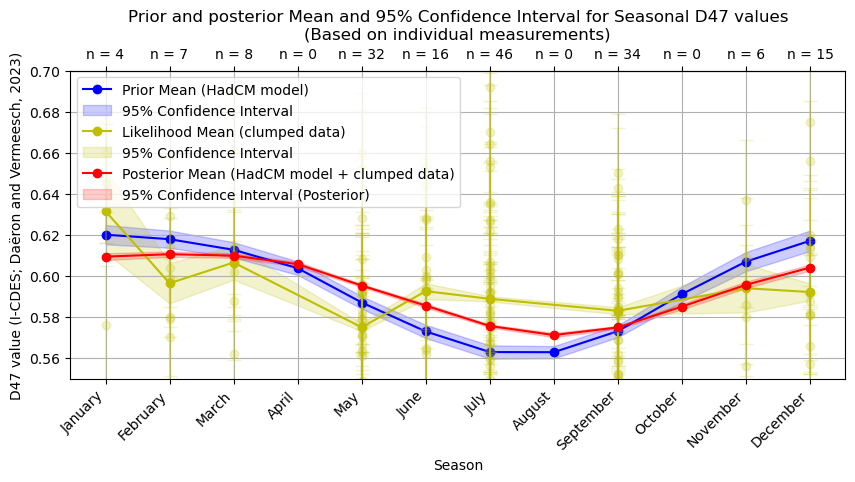

In [ ]:
# Plot the updated seasonal posterior
std_post_D47_monthly = np.sqrt(np.diag(cov_post_D47_monthly))
std_prior_D47_monthly_original = np.sqrt(np.diag(cov_prior_D47_monthly_original))

# Initiate figure
plt.figure(figsize = (10, 4))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_D47_monthly_original, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_original / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
valid_bins = mu_likelihood_monthly != 0 # Filter out bins where mu_likelihood_monthly is zero because these have no data
plt.plot(months_scale[valid_bins], mu_likelihood_monthly[valid_bins], label='Likelihood Mean (clumped data)', color='y', marker='o') # Add likelihood mean for valid bins

# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation) for valid bins
plt.fill_between(months_scale[valid_bins],
    mu_likelihood_monthly[valid_bins] - stats.t.ppf(1 - 0.025, n_update_monthly[valid_bins]) * std_likelihood_monthly[valid_bins] / np.sqrt(n_update_monthly[valid_bins]),
    mu_likelihood_monthly[valid_bins] + stats.t.ppf(1 - 0.025, n_update_monthly[valid_bins]) * std_likelihood_monthly[valid_bins] / np.sqrt(n_update_monthly[valid_bins]),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Lutetian_D47_data_dict: # Loop over measurements
    plt.plot(measurement["month_score"] + 1, measurement["D47_final"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"] + 1, measurement["D47_final"], yerr = measurement["D47_SD"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_D47_monthly, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_D47_monthly - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_D47_monthly / np.sqrt(n_update_monthly + n_models_monthly),
    mu_post_D47_monthly + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_D47_monthly / np.sqrt(n_update_monthly + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal D47 values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

# POSTERIOR - SEASONAL

## Updated seasonal prior in SAT and precipitation domain
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen and per season

### Convert seasonal prior, likelihood and posterior to temperature and plot

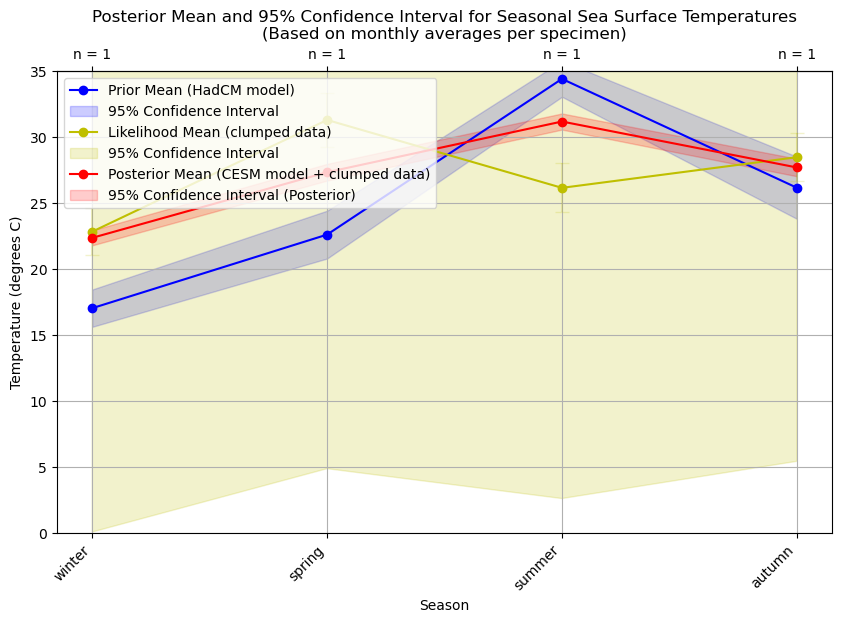

In [ ]:
# Convert prior D47 to temp
mu_prior_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal_original, sD47 = cov_prior_D47_seasonal_original, return_covar = True)[0]
cov_prior_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal_original, sD47 = cov_prior_D47_seasonal_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal_aggregated, sD47 = std_likelihood_seasonal_aggregated, return_covar = True)[0]
cov_likelihood_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal_aggregated, sD47 = std_likelihood_seasonal_aggregated, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_D47_seasonal_aggregated, sD47 = cov_post_D47_seasonal_aggregated, return_covar = True)[0]
cov_posterior_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_D47_seasonal_aggregated, sD47 = cov_post_D47_seasonal_aggregated, return_covar = True)[1]

# Plot in temperature domain
std_prior_D47_seasonal_aggregated_T = np.sqrt(np.diag(cov_prior_D47_seasonal_aggregated_T))
std_likelihood_seasonal_aggregated_T = np.sqrt(np.diag(cov_likelihood_seasonal_aggregated_T))
std_posterior_seasonal_aggregated_T = np.sqrt(np.diag(cov_posterior_seasonal_aggregated_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_aggregated_T, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_aggregated_T / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_aggregated_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal_aggregated_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated) * std_likelihood_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated),
    mu_likelihood_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated) * std_likelihood_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Lutetian_seasonally_aggregated_data_dict: # Loop over measurements
    plt.plot(measurement["season_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47_mean"], sD47 = measurement["D47_se"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47_mean"], sD47 = measurement["D47_se"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_mean"], sD47 = measurement["D47_se"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal_aggregated])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_seasonal_aggregated_T, label = 'Posterior Mean (CESM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_posterior_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    mu_posterior_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_posterior_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Sea Surface Temperatures\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot precipitation prior and posterior

C:\Users\nwi213\AppData\Local\Temp\ipykernel_21416\2277564928.py:3: RuntimeWarning: invalid value encountered in sqrt
  std_posterior_prec_seasonal_aggregated = np.nan_to_num(np.sqrt(np.diag(cov_post_prec_seasonal_aggregated)))


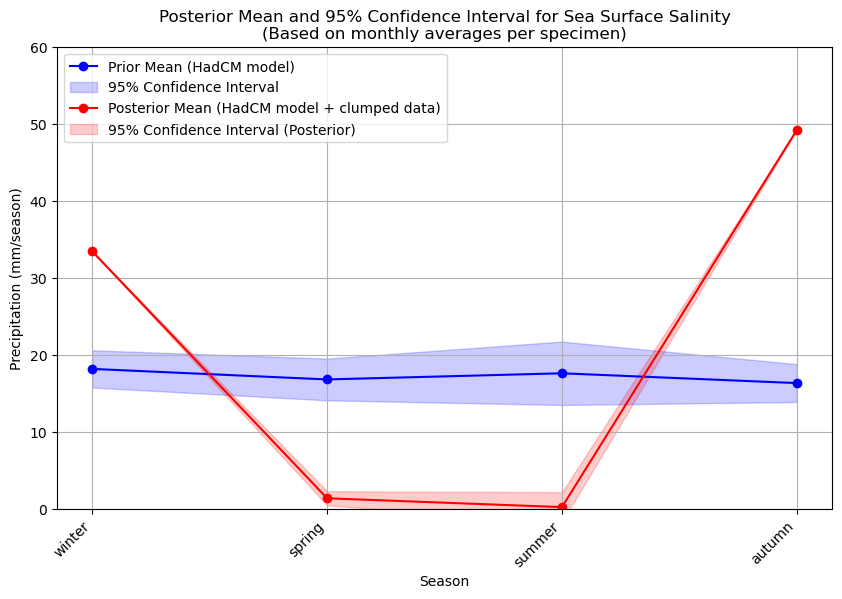

In [ ]:
# Plot in temperature domain, set nan values to zero
std_prior_prec_seasonal = np.nan_to_num(np.sqrt(np.diag(cov_prior_prec_seasonal_original)))
std_posterior_prec_seasonal_aggregated = np.nan_to_num(np.sqrt(np.diag(cov_post_prec_seasonal_aggregated)))

# Initiate plot
plt.figure(figsize=(10, 6))

# PRIOR
# Add prior mean in mm/season
plt.plot(seasons_scale, mu_prior_prec_seasonal_mm, label='Prior Mean (HadCM model)', color='b', marker='o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_prec_seasonal_mm - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
    mu_prior_prec_seasonal_mm + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean in mm/season
mu_post_prec_seasonal_mm = mu_post_prec_seasonal_aggregated * mm_per_day_to_mm_per_season
std_post_prec_seasonal_mm = std_posterior_prec_seasonal_aggregated * mm_per_day_to_mm_per_season

plt.plot(seasons_scale, mu_post_prec_seasonal_mm, label='Posterior Mean (HadCM model + clumped data)', color='r', marker='o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_prec_seasonal_mm - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_post_prec_seasonal_mm + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Sea Surface Salinity\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Precipitation (mm/season)')
plt.ylim(0, 60)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT and precipitation and posterior

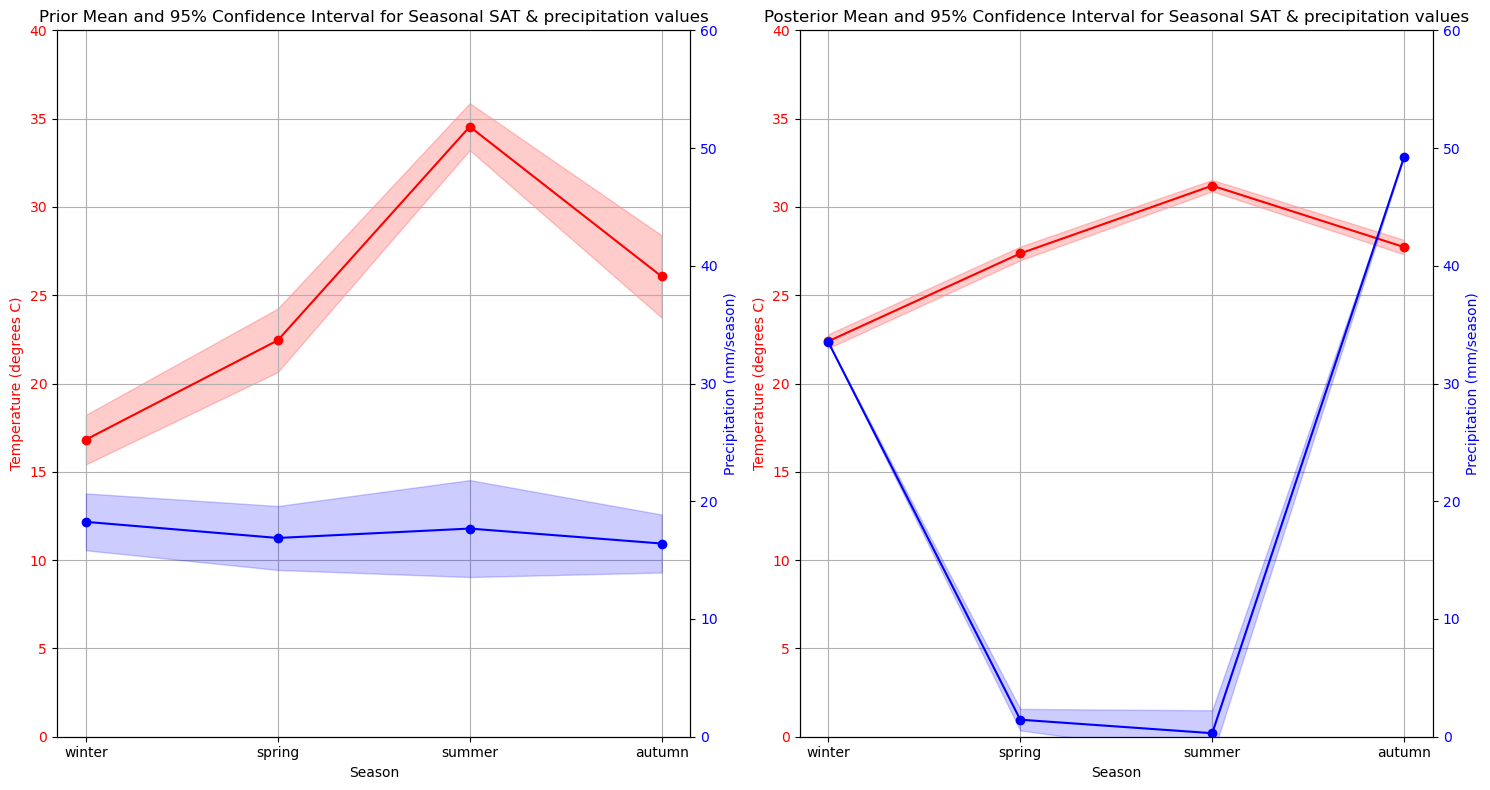

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot the prior distribution and confidence envelopes per season for SAT & precipitation
axes[0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o', color='r')
axes[0].fill_between(seasons_scale,
                     mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, color='r', label='95% Confidence Interval (SAT)')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SAT & precipitation values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C)', color='r')
axes[0].tick_params(axis='y', labelcolor='r')
axes[0].grid(True)
# Add a second y-axis for precipitation in mm/season
ax0_prec = axes[0].twinx()
ax0_prec.plot(seasons_scale, mu_prior_prec_seasonal_mm, label='Prior precipitation Mean', marker='o', color='b')
ax0_prec.fill_between(seasons_scale,
                      mu_prior_prec_seasonal_mm - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
                      mu_prior_prec_seasonal_mm + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
                      alpha=0.2, color='b', label='95% Confidence Interval (precipitation)')
ax0_prec.set_ylabel('Precipitation (mm/season)', color='b')
ax0_prec.tick_params(axis='y', labelcolor='b')

# Plot the posterior distribution and confidence envelopes per season for SAT & precipitation
axes[1].plot(seasons_scale, mu_posterior_seasonal_aggregated_T, label='Posterior SAT Mean', marker='o', color='r')
axes[1].fill_between(seasons_scale,
                     mu_posterior_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_seasonal_aggregated_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_posterior_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_seasonal_aggregated_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha=0.2, color='r', label='95% Confidence Interval (SAT)')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].set_title('Posterior Mean and 95% Confidence Interval for Seasonal SAT & precipitation values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C)', color='r')
axes[1].tick_params(axis='y', labelcolor='r')
axes[1].grid(True)

# Add a second y-axis for precipitation in mm/season
ax1_prec = axes[1].twinx()
ax1_prec.plot(seasons_scale, mu_post_prec_seasonal_mm, label='Posterior precipitation Mean', marker='o', color='b')
ax1_prec.fill_between(seasons_scale,
                      mu_post_prec_seasonal_mm - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
                      mu_post_prec_seasonal_mm + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
                      alpha=0.2, color='b', label='95% Confidence Interval (precipitation)')
ax1_prec.set_ylabel('Precipitation (mm/season)', color='b')
ax1_prec.tick_params(axis='y', labelcolor='b')

# Set equal limits for temperature and precipitation axes
axes[0].set_ylim(0, 40)
ax0_prec.set_ylim(0, 60)
axes[1].set_ylim(0, 40)
ax1_prec.set_ylim(0, 60)

plt.tight_layout()
plt.show()

## Updated seasonal prior in SAT and precipitation domain
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 data aggregated as individual datapoints

### Convert seasonal prior, likelihood and posterior to temperature and plot

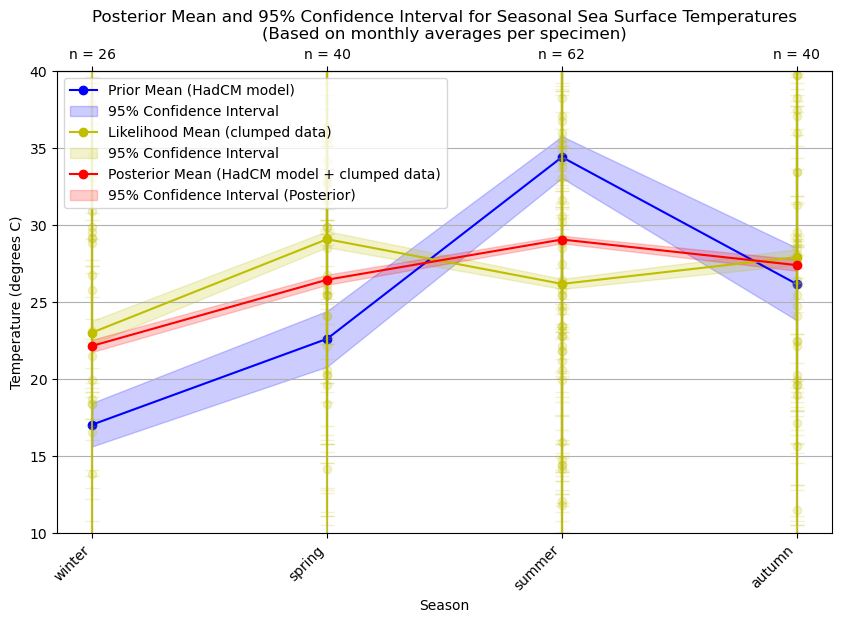

In [ ]:
# Convert prior D47 to temp
mu_prior_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal_original, sD47 = cov_prior_D47_seasonal_original, return_covar = True)[0]
cov_prior_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal_original, sD47 = cov_prior_D47_seasonal_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal, sD47 = std_likelihood_seasonal, return_covar = True)[0]
cov_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal, sD47 = std_likelihood_seasonal, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_seasonal_T = D47c.OGLS23.T47(D47 = mu_post_D47_seasonal, sD47 = cov_post_D47_seasonal, return_covar = True)[0]
cov_posterior_seasonal_T = D47c.OGLS23.T47(D47 = mu_post_D47_seasonal, sD47 = cov_post_D47_seasonal, return_covar = True)[1]

# Plot in temperature domain
std_prior_D47_seasonal_T = np.sqrt(np.diag(cov_prior_D47_seasonal_T))
std_likelihood_seasonal_T = np.sqrt(np.diag(cov_likelihood_seasonal_T))
std_posterior_seasonal_T = np.sqrt(np.diag(cov_posterior_seasonal_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_T, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal_T - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal_T / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal_T + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal_T / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Lutetian_D47_data_dict: # Loop over measurements
    plt.plot(measurement["season_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47_final"], sD47 = measurement["D47_SD"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47_final"], sD47 = measurement["D47_SD"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_final"], sD47 = measurement["D47_SD"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_seasonal_T, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_seasonal_T - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_posterior_seasonal_T + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Sea Surface Temperatures\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(10, 40)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot precipitation prior and posterior

C:\Users\nwi213\AppData\Local\Temp\ipykernel_21416\1878817324.py:3: RuntimeWarning: invalid value encountered in sqrt
  std_posterior_prec_seasonal = np.nan_to_num(np.sqrt(np.diag(cov_post_prec_seasonal)))


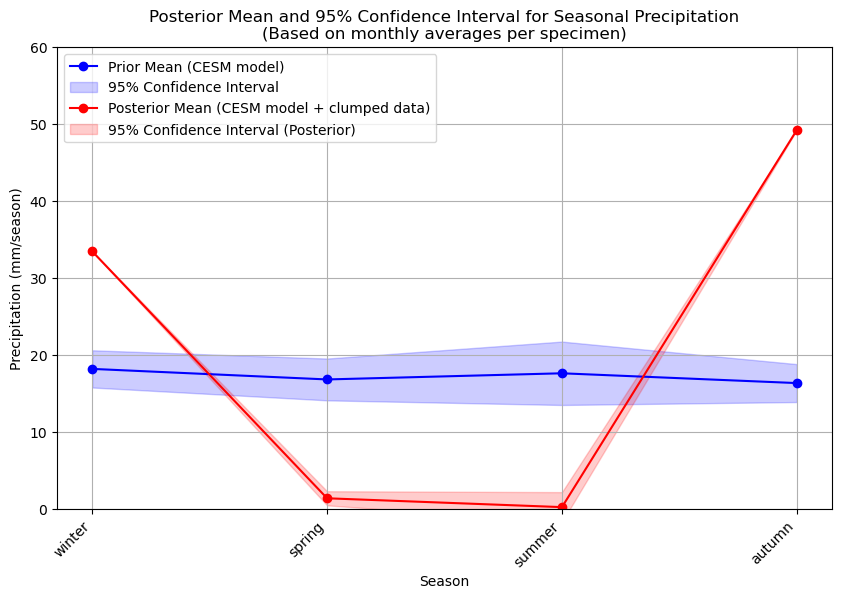

In [ ]:
# Plot in temperature domain, set nan values to zero
std_prior_prec_seasonal = np.nan_to_num(np.sqrt(np.diag(cov_prior_prec_seasonal_original)))
std_posterior_prec_seasonal = np.nan_to_num(np.sqrt(np.diag(cov_post_prec_seasonal)))

# Initiate plot
plt.figure(figsize = (10, 6))
# PRIOR
# Add prior mean in mm/season
plt.plot(seasons_scale, mu_prior_prec_seasonal_mm, label='Prior Mean (CESM model)', color='b', marker='o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_prec_seasonal_mm - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
    mu_prior_prec_seasonal_mm + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean in mm/season
plt.plot(seasons_scale, mu_post_prec_seasonal_mm, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_prec_seasonal_mm - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_post_prec_seasonal_mm + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation=45, ha="right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Precipitation\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Precipitation (mm/season)')
plt.ylim(0, 60)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Plot SAT and precipitation posterior

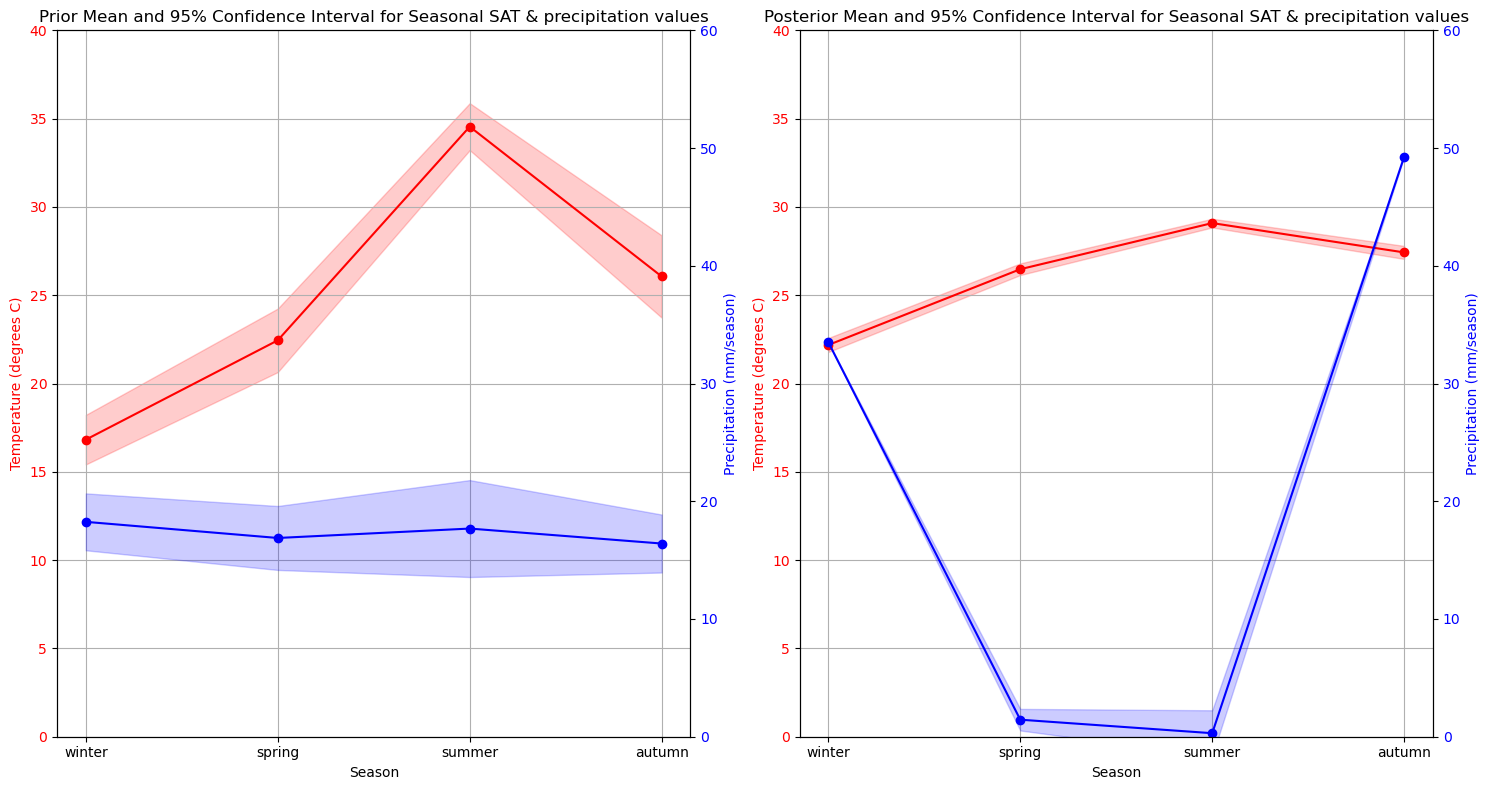

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot the prior distribution and confidence envelopes per season for SAT & prec
axes[0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o', color='r')
axes[0].fill_between(seasons_scale,
                     mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, color='r', label='95% Confidence Interval (SAT)')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SAT & precipitation values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C)', color='r')
axes[0].tick_params(axis='y', labelcolor='r')
axes[0].grid(True)

# Add a second y-axis for precipitation in mm per season
ax0_prec = axes[0].twinx()
ax0_prec.plot(seasons_scale, mu_prior_prec_seasonal_mm, label='Prior precipitation Mean', marker='o', color='b')
ax0_prec.fill_between(seasons_scale,
                      mu_prior_prec_seasonal_mm - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
                      mu_prior_prec_seasonal_mm + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
                      alpha=0.2, color='b', label='95% Confidence Interval (precipitation)')
ax0_prec.set_ylabel('Precipitation (mm/season)', color='b')
ax0_prec.tick_params(axis='y', labelcolor='b')

# Plot the posterior distribution and confidence envelopes per season for SAT & prec
axes[1].plot(seasons_scale, mu_posterior_seasonal_T, label='Posterior SAT Mean', marker='o', color='r')
axes[1].fill_between(seasons_scale,
                     mu_posterior_seasonal_T - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_posterior_seasonal_T + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha=0.2, color='r', label='95% Confidence Interval (SAT)')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].set_title('Posterior Mean and 95% Confidence Interval for Seasonal SAT & precipitation values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C)', color='r')
axes[1].tick_params(axis='y', labelcolor='r')
axes[1].grid(True)

# Add a second y-axis for precipitation in mm per season
ax1_prec = axes[1].twinx()
ax1_prec.plot(seasons_scale, mu_post_prec_seasonal_mm, label='Posterior precipitation Mean', marker='o', color='b')
ax1_prec.fill_between(seasons_scale,
                      mu_post_prec_seasonal_mm - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
                      mu_post_prec_seasonal_mm + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
                      alpha=0.2, color='b', label='95% Confidence Interval (precipitation)')
ax1_prec.set_ylabel('Precipitation (mm/season)', color='b')
ax1_prec.tick_params(axis='y', labelcolor='b')

# Set equal limits for temperature and precipitation axes
axes[0].set_ylim(0, 40)
ax0_prec.set_ylim(0, 60)
axes[1].set_ylim(0, 40)
ax1_prec.set_ylim(0, 60)

plt.tight_layout()
plt.show()

# POSTERIOR - MONTHLY

## Updated monthly prior in SAT and precipitation domain
* Data and model outcomes aggregated in 12 months
* No sclero-dating uncertainty
* D47 data aggregated as individual datapoints

### Convert seasonal prior, likelihood and posterior to temperature and plot

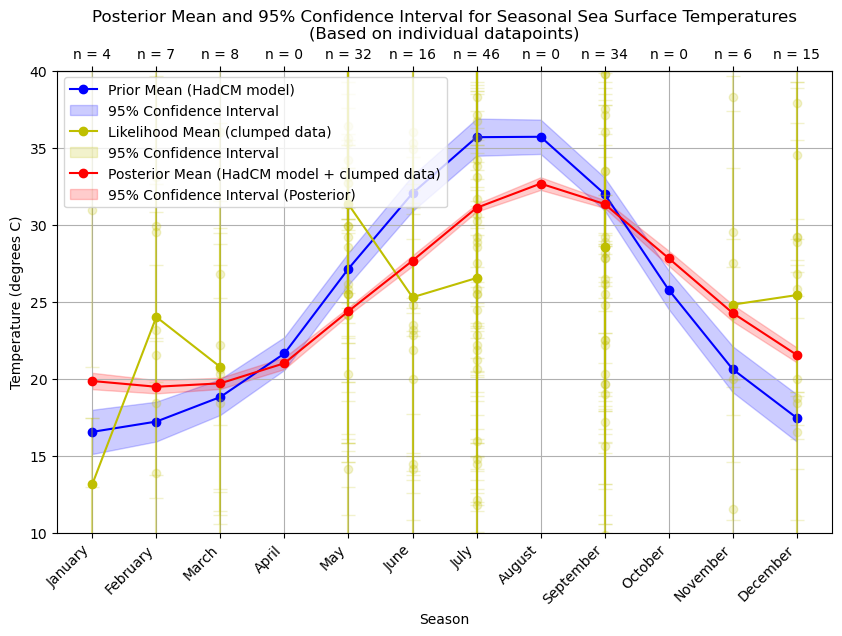

In [ ]:
# Convert prior D47 to temp
mu_prior_D47_monthly_T = D47c.OGLS23.T47(D47=mu_prior_D47_monthly_original, sD47=cov_prior_D47_monthly_original, return_covar=True)[0]
cov_prior_D47_monthly_T = D47c.OGLS23.T47(D47=mu_prior_D47_monthly_original, sD47=cov_prior_D47_monthly_original, return_covar=True)[1]

# Convert likelihood D47 to temp, replacing zeroes with NA
mu_likelihood_monthly_with_na = np.where(mu_likelihood_monthly == 0, np.nan, mu_likelihood_monthly)
std_likelihood_monthly_with_na = np.where(std_likelihood_monthly == 0, np.nan, std_likelihood_monthly)
mu_likelihood_monthly_T = D47c.OGLS23.T47(D47=mu_likelihood_monthly_with_na, sD47=std_likelihood_monthly_with_na, return_covar=True)[0]
cov_likelihood_monthly_T = D47c.OGLS23.T47(D47=mu_likelihood_monthly_with_na, sD47=std_likelihood_monthly_with_na, return_covar=True)[1]

# Convert posterior D47 to temp
mu_posterior_monthly_T = D47c.OGLS23.T47(D47=mu_post_D47_monthly, sD47=cov_post_D47_monthly, return_covar=True)[0]
cov_posterior_monthly_T = D47c.OGLS23.T47(D47=mu_post_D47_monthly, sD47=cov_post_D47_monthly, return_covar=True)[1]

# Plot in temperature domain
std_prior_D47_monthly_T = np.sqrt(np.diag(cov_prior_D47_monthly_T))
std_likelihood_monthly_T = np.sqrt(np.diag(cov_likelihood_monthly_T))
std_posterior_monthly_T = np.sqrt(np.diag(cov_posterior_monthly_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_D47_monthly_T, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_T / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly_T - stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly_T / np.sqrt(n_update_monthly),
    mu_likelihood_monthly_T + stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly_T / np.sqrt(n_update_monthly), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Lutetian_D47_data_dict: # Loop over measurements
    plt.plot(measurement["month_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47_final"], sD47 = measurement["D47_SD"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47_final"], sD47 = measurement["D47_SD"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_final"], sD47 = measurement["D47_SD"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_posterior_monthly_T, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_posterior_monthly_T - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
    mu_posterior_monthly_T + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Sea Surface Temperatures\n(Based on individual datapoints)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(10, 40)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot precipitation prior and posterior

C:\Users\nwi213\AppData\Local\Temp\ipykernel_21416\1737634915.py:3: RuntimeWarning: invalid value encountered in sqrt
  std_posterior_prec_monthly = np.nan_to_num(np.sqrt(np.diag(cov_post_prec_monthly)))


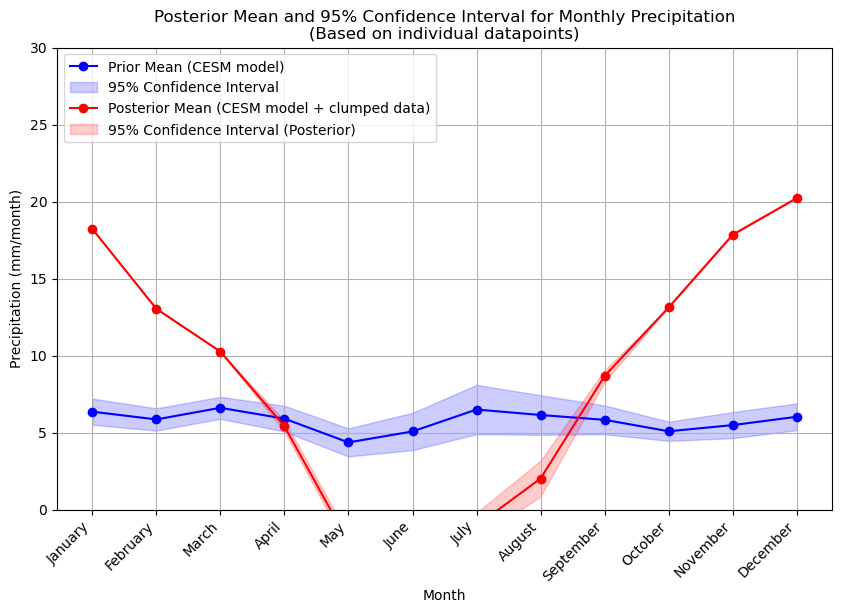

In [ ]:
# Plot in temperature domain, set nan values to zero
std_prior_prec_monthly = np.nan_to_num(np.sqrt(np.diag(cov_prior_prec_monthly_original)))
std_posterior_prec_monthly = np.nan_to_num(np.sqrt(np.diag(cov_post_prec_monthly)))

# Initiate plot
plt.figure(figsize=(10, 6))

# PRIOR
# Add prior mean in mm/month
mu_prior_prec_monthly_mm = mu_prior_prec_monthly * mm_per_day_to_mm_per_month
std_prior_prec_monthly_mm = std_prior_prec_monthly * mm_per_day_to_mm_per_month

plt.plot(months_scale, mu_prior_prec_monthly_mm, label='Prior Mean (CESM model)', color='b', marker='o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_prec_monthly_mm - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_prec_monthly_mm / np.sqrt(n_models_monthly),
    mu_prior_prec_monthly_mm + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_prec_monthly_mm / np.sqrt(n_models_monthly),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean in mm/month
mu_post_prec_monthly_mm = mu_post_prec_monthly * mm_per_day_to_mm_per_month
std_post_prec_monthly_mm = std_posterior_prec_monthly * mm_per_day_to_mm_per_month

plt.plot(months_scale, mu_post_prec_monthly_mm, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_prec_monthly_mm - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_prec_monthly_mm / np.sqrt(n_update_monthly + n_models_monthly),
    mu_post_prec_monthly_mm + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_prec_monthly_mm / np.sqrt(n_update_monthly + n_models_monthly),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Precipitation\n(Based on individual datapoints)')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm/month)')
plt.ylim(0, 30)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Plot SAT and precipitation and posterior

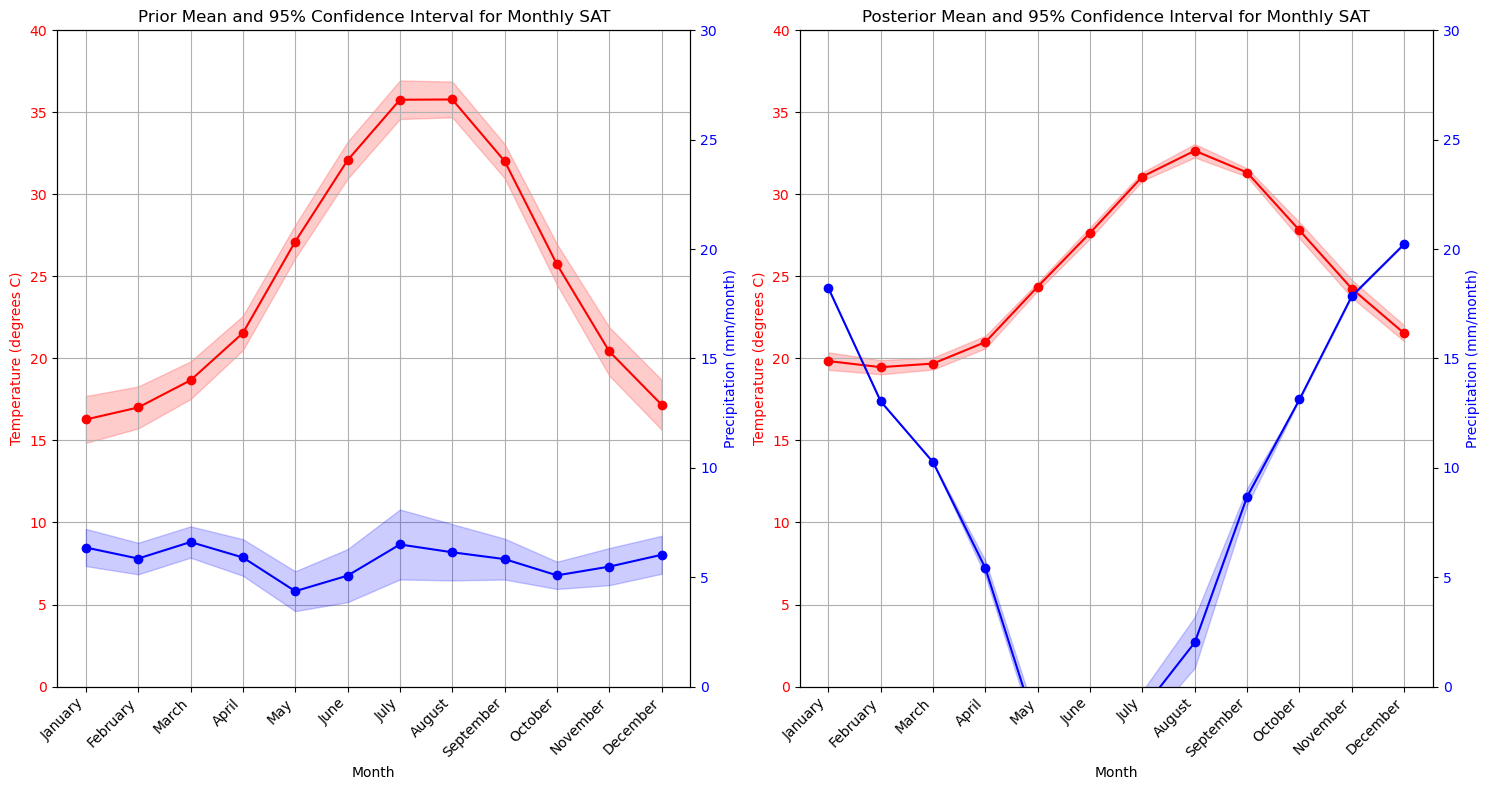

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot the prior distribution and confidence envelopes per month for SAT & precipitation
axes[0].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker='o', color='r')
axes[0].fill_between(months_scale,
                     mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
                     alpha=0.2, color='r', label='95% Confidence Interval (SAT)')
axes[0].set_xticks(months_scale)
axes[0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0].set_title('Prior Mean and 95% Confidence Interval for Monthly SAT')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Temperature (degrees C)', color='r')
axes[0].tick_params(axis='y', labelcolor='r')
axes[0].grid(True)

# Add a second y-axis for precipitation in mm/month
ax0_prec = axes[0].twinx()
ax0_prec.plot(months_scale, mu_prior_prec_monthly_mm, label='Prior precipitation Mean', marker='o', color='b')
ax0_prec.fill_between(months_scale,
                      mu_prior_prec_monthly_mm - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_prec_monthly_mm / np.sqrt(n_models_monthly),
                      mu_prior_prec_monthly_mm + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_prec_monthly_mm / np.sqrt(n_models_monthly),
                      alpha=0.2, color='b', label='95% Confidence Interval (precipitation)')
ax0_prec.set_ylabel('Precipitation (mm/month)', color='b')
ax0_prec.tick_params(axis='y', labelcolor='b')

# Plot the posterior distribution and confidence envelopes per month for SAT & precipitation
axes[1].plot(months_scale, mu_posterior_monthly_T, label='Posterior SAT Mean', marker='o', color='r')
axes[1].fill_between(months_scale,
                     mu_posterior_monthly_T - stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_posterior_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
                     mu_posterior_monthly_T + stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_posterior_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
                     alpha=0.2, color='r', label='95% Confidence Interval (SAT)')
axes[1].set_xticks(months_scale)
axes[1].set_xticklabels(month_names, rotation=45, ha="right")
axes[1].set_title('Posterior Mean and 95% Confidence Interval for Monthly SAT')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Temperature (degrees C)', color='r')
axes[1].tick_params(axis='y', labelcolor='r')
axes[1].grid(True)

# Add a second y-axis for precipitation in mm/month
ax1_prec = axes[1].twinx()
ax1_prec.plot(months_scale, mu_post_prec_monthly_mm, label='Posterior precipitation Mean', marker='o', color='b')
ax1_prec.fill_between(months_scale,
                      mu_post_prec_monthly_mm - stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_prec_monthly_mm / np.sqrt(n_update_monthly + n_models_monthly),
                      mu_post_prec_monthly_mm + stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_prec_monthly_mm / np.sqrt(n_update_monthly + n_models_monthly),
                      alpha=0.2, color='b', label='95% Confidence Interval (precipitation)')
ax1_prec.set_ylabel('Precipitation (mm/month)', color='b')
ax1_prec.tick_params(axis='y', labelcolor='b')

# Set equal limits for temperature and precipitation axes
axes[0].set_ylim(0, 40)
ax0_prec.set_ylim(0, 30)
axes[1].set_ylim(0, 40)
ax1_prec.set_ylim(0, 30)

plt.tight_layout()
plt.show()